# All-e market research
This notebook contains the data analysis for the all-e market research.  

## contents
1) Loading daily aggregated data from Clickhouse / local.
2) Fitting a heat demand vs. ambiant temperature model per cic.
3) Fitting a water temp vs. ambiant temperature model per cic.
4) Extrapolating both to make a plot at -10, -5 and 0 degrees for each cic.
5) Plotting in the same figure the maximum available heat production.


to do:
- filter out cic's with more than 10 missing days (cic swaps?)
- check filtering of outliers, especially for water supply model
- check if we can filter out houses in a certain way
- is there a way to make sure that we are looking an accurate representation?
- is 5kWh going to make a significant impact?

In [14]:
import clickhouse_connect
import pandas as pd
from pathlib import Path
from dotenv import load_dotenv
import os
from os import path
from plotly import colors
import plotly.express as px 
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import statsmodels.api as sm
from sklearn.linear_model import TheilSenRegressor, LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from pyod.models.cd import CD
from pyod.models.thresholds import FWFM
from scipy.optimize import curve_fit
import numpy as np
from sqlalchemy import create_engine
from urllib.parse import urlparse
from requests import HTTPError
from math import radians, cos, sin, asin, sqrt
from knmy import knmy
import pgeocode
from datetime import datetime
import matplotlib.pyplot as plt


# PLotting theme
pio.templates.default = "plotly_white"

In [2]:
# Load username and password from .env file
env_path = Path('../') / '.env'
load_dotenv(env_path)

True

## 2) data cleaning and definition of models

In [ ]:
def plot_metric_distribution(df, metric_name, savings_thresholds, actual_savings_col='actualSavings'):
    """
    Plot the distribution of a given metric for different savings thresholds
    Inputs:
        df: dataframe
        metric_name: name of the metric
        savings_thresholds: list of savings thresholds
        actual_savings_col: name of the column containing the actual savings
    """
    subplot_titles = []
    for savings_threshold in savings_thresholds:
        df_tmp = df[df[actual_savings_col] >= savings_threshold]
        subplot_titles.append(f"Savings Threshold: {savings_threshold}: number of CiCs: {len(df_tmp)}, Savings mean +- 3 sigma: {df_tmp[metric_name].mean():.2f} +- {3 * df_tmp[metric_name].std():.2f}")

    # Create a figure with subplots
    fig = make_subplots(rows=len(savings_thresholds), cols=1, subplot_titles=subplot_titles, vertical_spacing=0.1)

    # Iterate over each savings threshold
    for i, threshold in enumerate(savings_thresholds):
        # Filter the dataframe to include only rows with savings above the threshold
        df_filtered = df[df[actual_savings_col] >= threshold]

        # Add a histogram of the metric to the subplot
        fig.add_trace(px.histogram(df_filtered, x=metric_name, nbins=50).data[0], row=i+1, col=1)

        # Set the subplot title
        fig.update_yaxes(title_text=f"Count", row=i+1, col=1, matches='y')
        fig.update_xaxes(title_text=metric_name, row=i+1, col=1, matches='x')

    # Update the figure layout
    fig.update_layout(height=800, title_text=f"Distribution of {metric_name} by Savings Threshold")
    fig.show()


In [ ]:
def plot_actual_and_estimated_by_cic(df, actual_col, estimated_col, title):
    """
    Plot the actual and estimated values of a given metric for each CiC
    Inputs:
        df: dataframe
        actual_col: name of the column containing the actual values
        estimated_col: name of the column containing the estimated values
        title: title of the plot
    """
    # Get a list of unique CiCs
    cics = df['cic_id'].unique()

    # Create a figure with two subplots for each CiC
    fig = make_subplots(rows=2, cols=1, subplot_titles=[f"Actual and Estimated {actual_col}", f"Cumulative Actual and Estimated {actual_col}"])

    # Iterate over each CiC
    for i, cic in enumerate(cics):
        # Filter the dataframe to include only rows for the current CiC
        df_cic = df[df['cic_id'] == cic]

        # Set the color of the traces based on the index of the current CiC in the list of unique CiCs
        color = px.colors.qualitative.Plotly[i % len(px.colors.qualitative.Plotly)]

        # Add a scatter plot of actual vs estimated metric to the first subplot
        fig.add_trace(go.Scatter(x=df_cic['date'], y=df_cic[actual_col], mode='markers', name=f'{cic} Actual', legendgroup=cic, visible='legendonly', marker_color=color), row=1, col=1)
        fig.add_trace(go.Scatter(x=df_cic['date'], y=df_cic[estimated_col], mode='lines', name='Estimated', legendgroup=cic, visible='legendonly', line_color=color), row=1, col=1)

        # Add a scatter plot of cumulated actual vs estimated metric to the second subplot
        fig.add_trace(go.Scatter(x=df_cic['date'], y=df_cic[actual_col].cumsum(), mode='markers', name='Actual', legendgroup=cic, visible='legendonly', marker_color=color), row=2, col=1)
        fig.add_trace(go.Scatter(x=df_cic['date'], y=df_cic[estimated_col].cumsum(), mode='lines', name='Estimated', legendgroup=cic, visible='legendonly', line_color=color), row=2, col=1)

    # Update the subplot layout
    fig.update_xaxes(title_text='Date', row=1, col=2)
    fig.update_yaxes(title_text=actual_col, row=1, col=1)
    fig.update_yaxes(title_text=f'Cumulative {actual_col}', row=2, col=1)
    fig.update_xaxes(matches='x')

    # Update the figure layout
    fig.update_layout(height=800, title_text=title)

    # Show the plot
    fig.show()


In [11]:
# Define the model functions and data filters
# - Heat demand model: Q_house = c0 * Ta + c1
# - HP heat ratio model: hpHeatRatio = 1 / (1 + exp(-(c2 * Ta + c3)))
# - Summer mode model: summerMode = 1 / (1 + exp((c4 * Ta + c5)))
# - COP model: COP = c6 * Ta + c7
# - HP heat delivered model: Q_hp = Q_house * hpHeatRatio * summerMode
# - HP energy consumed model: E_hp = Q_hp / COP
# - Savings model: savings = hpHeatRatio * Q_house * summerMode * ((cost_gas / calorific_value_gas) - cost_electricity / COP)
# - Filter outliers: Use CD with FWFM to remove outliers
# - Filter data for COP model: Remove rows where Q_hp < min_Q_hp, COP < min_COP or > max_cop
# - Filter data for heat demand model: Remove rows where Q_house < min_Q_house
# - Filter data for HP heat ratio model: Remove rows where Q_house < min_Q_house
# - Filter data for summer mode model: Remove rows where Q_hp < min_Q_hp
# - Filter data for complete model: Remove rows where Q_hp < min_Q

def heat_demand_model(Ta, c0, c1):
    return c0 * Ta + c1

def hp_heat_ratio_model(Ta, c2, c3):
    return 1 / (1 + np.exp(-(c2 * Ta + c3)))

def summer_mode_model(Ta, c4, c5):
    return ( (1 / (1 + np.exp((c4 * Ta + c5)))))

def cop_model(Ta, c6, c7):
    return c6 * Ta + c7

def hp_heat_delivered_model(Ta, heat_demand_model_params, hp_heat_ratio_model_params, summer_mode_model_params):
    return heat_demand_model(Ta, *heat_demand_model_params) * hp_heat_ratio_model(Ta, *hp_heat_ratio_model_params) * summer_mode_model(Ta, *summer_mode_model_params)

def hp_energy_consumed_model(Ta, heat_demand_model_params, hp_heat_ratio_model_params, summer_mode_model_params, cop_model_params):
    return hp_heat_delivered_model(Ta, heat_demand_model_params, hp_heat_ratio_model_params, summer_mode_model_params) / cop_model(Ta, *cop_model_params)

def savings_model(Ta, heat_demand_model_params, hp_heat_ratio_model_params, summer_mode_model_params, cop_model_params, min_cop=1):
        cost_gas = 1.46 # €/m3
        cost_electricity = 0.36 # €/kWh
        calorific_value_gas = 8.8 # kWh/m3
        return hp_heat_delivered_model(Ta, heat_demand_model_params, hp_heat_ratio_model_params, summer_mode_model_params) * ((cost_gas / calorific_value_gas) - (cost_electricity / np.clip(cop_model(Ta, *cop_model_params), min_cop, np.Inf)))

# Define the model function
def savings_model_detailed(Ta, heat_demand_model_params, hp_heat_ratio_model_params, summer_mode_model_params, cop_model_params, min_cop=1):
    house_heat_demand = heat_demand_model(Ta, *heat_demand_model_params)
    hp_heat_delivered = hp_heat_ratio_model(Ta, *hp_heat_ratio_model_params) * house_heat_demand * summer_mode_model(Ta, *summer_mode_model_params)
    hp_energy_consumed = hp_heat_delivered / np.clip(cop_model(Ta, *cop_model_params), min_cop, np.Inf)
    savings = savings_model(Ta, heat_demand_model_params, hp_heat_ratio_model_params, summer_mode_model_params, cop_model_params, min_cop=min_cop)
    return savings, house_heat_demand,hp_heat_delivered, hp_energy_consumed

def filterOutliers(df, Q_hpCol='Q_hp', Q_houseCol='Q_house', min_Q = 1, inplace=False):
    if inplace:
        df_cic = df
    else:
        df_cic = df.copy()
    
    # Remove rows where Q < min_Q
    df_cic = df_cic[df_cic[Q_hpCol] > min_Q]
    df_cic = df_cic[df_cic[Q_houseCol] > min_Q]

    # Use CD with FWFM to remove outliers
    X = df_cic[[Q_hpCol, Q_houseCol]].to_numpy()
    model = CD(contamination=FWFM())
    model.fit(X)
    y_pred = model.predict(X)
    df_cic['outlier'] = y_pred
    df_cic = df_cic[df_cic['outlier'] == 0]
    return df_cic

def filterDataForCopModel(df, min_Q_hp=2, min_COP = 0.5, max_cop = 15, inplace=False):
    if inplace:
        df_heating = df
    else:
        df_heating = df.copy()

    # Remove rows where Q_hp < min_Q_hp
    df_heating = df[(df['Q_hp'] >= min_Q_hp)]

    # Remove rows where COP < min_COP or > max_cop
    df_heating = df_heating[(df_heating['COP'] >= min_COP) & (df_heating['COP'] <= max_cop)]
    
    # Sort df_heating by ambientTemperature
    df_heating = df_heating.sort_values(by=['ambientTemperature'])
    return df_heating

def filterDataForHeatDemandModel(df, min_Q_house=3, inplace=False):
    if inplace:
        df_ss = df
    else:
        df_ss = df.copy()
    
    # Remove rows where Q_house < min_Q_house
    df_ss = df_ss[(df_ss['Q_house'] >= min_Q_house)]
    # # Remove rows where roomTemperatureError > 1.0 or < -1.0
    # df_ss = df_ss[(df_ss['roomTemperatureError'] <= room_temperature_error_threshold) &
    # (df_ss['roomTemperatureError'] >= -room_temperature_error_threshold)]
    return df_ss

def filterDataForHpRatioModel(df_cic, min_Q_house=3, inplace=False, hpRatioCol='hpHeatRatio', Q_houseCol='Q_house'):
    if not inplace:
        df_cic = df_cic.copy()
    
    df_cic = df_cic[df_cic[Q_houseCol] > min_Q_house]
    df_cic[hpRatioCol] = df_cic[Q_houseCol] / df_cic['Q_hp']
    
    return df_cic


def filterDataForSummerModeModel(df_cic, min_Q_hp = 3, inplace=False):
    if not inplace:
        df_cic = df_cic.copy()

    df_cic['summerMode'] = (df_cic['Q_hp'] < min_Q_hp).astype(int)
    return df_cic

def filterDataForCompleteModel(df_cic, min_Q = 3, inplace=False):
    if not inplace:
        df_cic = df_cic.copy()
    
    df_cic = df_cic[df_cic['Q_hp'] > min_Q]
    return df_cic

In [ ]:
def estimate_model_parameters(df_cic):
    """
    Estimate the parameters of the complete model
    Inputs:
        df_cic: dataframe containing the data for a single CiC
    Outputs:
        popt: array of parameter values
        pcov: covariance matrix
    """
    
    # Estimate parameters of individual components of the model
    p0_heat_demand = [-4.4, 72.2]
    df_cic_heat_demand = filterOutliers(df_cic, inplace=False)
    popt_heat_demand, _ = curve_fit(heat_demand_model, df_cic_heat_demand['ambientTemperature'], df_cic_heat_demand['Q_house'], p0=p0_heat_demand)

    p0_hp_heat_ratio = [0.26, 0.79]
    df_cic_hp_heat_ratio = filterOutliers(df_cic, inplace=False)
    df_cic_hp_heat_ratio = filterDataForHpRatioModel(df_cic_hp_heat_ratio, inplace=False)
    popt_hp_heat_ratio, _ = curve_fit(hp_heat_ratio_model, df_cic_hp_heat_ratio['ambientTemperature'], df_cic_hp_heat_ratio['Q_hp'] / df_cic_hp_heat_ratio['Q_house'], p0=p0_hp_heat_ratio)

    df_cic_summer_mode = filterDataForSummerModeModel(df_cic, inplace=False)
    # Use sklearn LogisticRegression to fit a logistic model to summerMode as a function of ambientTemperature
    X = df_cic_summer_mode['ambientTemperature'].to_numpy().reshape(-1, 1)
    y = df_cic_summer_mode['summerMode'].to_numpy()
    modelSummerMode = make_pipeline(LogisticRegression(random_state=0, C=1e5, class_weight={0: 0.5, 1: 0.5})).fit(X, y)
    popt_summer_mode = np.concatenate([modelSummerMode['logisticregression'].coef_[0], modelSummerMode['logisticregression'].intercept_])

    p0_cop = [0.22, 2.25]
    df_cic_cop = filterOutliers(df_cic, inplace=False)
    df_cic_cop = filterDataForCopModel(df_cic_cop, inplace=False)
    popt_cop, _ = curve_fit(cop_model, df_cic_cop['ambientTemperature'], df_cic_cop['COP'], p0=p0_cop)

    # Define initial guess for model parameters
    p0 = np.concatenate([popt_heat_demand, popt_hp_heat_ratio, popt_summer_mode, popt_cop])
    
    # Define bounds for model parameters
    # bounds = ([-20, 20, 0, -1, -3000, -2000, -1, -7], 
    #           [-1, 400, 3, 14, np.Inf, 2000, 1, 7])
    # bounds = ([-20, 20, 0, -2, 0.15, -30, -1, -7], 
    #           [-1, 400, 2, 4, 2.0, -1, 1, 7])
    bounds = ([-20, 20, popt_hp_heat_ratio[0], popt_hp_heat_ratio[1], popt_summer_mode[0], popt_summer_mode[1], -1, -7], 
              [-1, 400, popt_hp_heat_ratio[0] + 1e-6, popt_hp_heat_ratio[1] + 1e-6, popt_summer_mode[0] + 1e-6, popt_summer_mode[1] + 1e-6, 1, 7])
    
    if any(p0 < bounds[0]) or any(p0 > bounds[1]):
        print(f"Initial params: {p0} \nBounds: {bounds}")
        return None, None

    # Filter data for complete model
    df_cic_heating = filterDataForCompleteModel(df_cic, inplace=False)

    # Fit the model to the data
    try:
        popt, pcov = curve_fit(savings_model, df_cic_heating['ambientTemperature'], df_cic_heating['savings'], p0=p0, bounds=bounds)
    except ValueError as e:
        print(f"Initial params: {p0} \n{e}")
        return None, None

    # Define parameter names for the complete model
    param_names = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']

    # Create a dictionary of parameter names and values for the complete model
    param_dict = {param_names[i]: popt[i] for i in range(len(param_names))}

    return popt, pcov


In [ ]:
def decouple_estimate_model_parameters(df_cic):
    """
    Estimate the parameters of the complete model in a decoupled manner - first estimate the parameters of the individual components of the model and then combine them
    Inputs:
        df_cic: dataframe containing the data for a single CiC
    Outputs:
        popt: array of parameter values
        pcov: covariance matrix
    """
    # Estimate parameters of individual components of the model
    p0_heat_demand = [-4.4, 72.2]
    df_cic_heat_demand = filterOutliers(df_cic, inplace=False)
    df_cic_heat_demand = filterDataForHeatDemandModel(df_cic_heat_demand, inplace=False)
    # popt_heat_demand, _ = curve_fit(heat_demand_model, df_cic_heat_demand['ambientTemperature'], df_cic_heat_demand['Q_house'], p0=p0_heat_demand)
    X = df_cic_heat_demand['ambientTemperature'].to_numpy().reshape(-1, 1)
    y = df_cic_heat_demand['Q_house'].to_numpy()
    modelHeatDemand = TheilSenRegressor(random_state=0).fit(X, y)
    popt_heat_demand = [list(modelHeatDemand.coef_)[0], modelHeatDemand.intercept_]

    p0_hp_heat_ratio = [0.26, 0.79]
    df_cic_hp_heat_ratio = filterOutliers(df_cic, inplace=False)
    df_cic_hp_heat_ratio = filterDataForHpRatioModel(df_cic_hp_heat_ratio, inplace=False)
    popt_hp_heat_ratio, _ = curve_fit(hp_heat_ratio_model, df_cic_hp_heat_ratio['ambientTemperature'], df_cic_hp_heat_ratio['Q_hp'] / df_cic_hp_heat_ratio['Q_house'], p0=p0_hp_heat_ratio)

    df_cic_summer_mode = filterDataForSummerModeModel(df_cic, inplace=False)
    # Use sklearn LogisticRegression to fit a logistic model to summerMode as a function of ambientTemperature
    X = df_cic_summer_mode['ambientTemperature'].to_numpy().reshape(-1, 1)
    y = df_cic_summer_mode['summerMode'].to_numpy()
    modelSummerMode = make_pipeline(LogisticRegression(random_state=0, C=1e5, class_weight={0: 0.5, 1: 0.5})).fit(X, y)
    popt_summer_mode = np.concatenate([modelSummerMode['logisticregression'].coef_[0], modelSummerMode['logisticregression'].intercept_])

    p0_cop = [0.22, 2.25]
    df_cic_cop = filterOutliers(df_cic, inplace=False)
    df_cic_cop = filterDataForCopModel(df_cic, inplace=False)
    # popt_cop, _ = curve_fit(cop_model, df_cic_cop['ambientTemperature'], df_cic_cop['COP'], p0=p0_cop)
    X = df_cic_cop['ambientTemperature'].to_numpy().reshape(-1, 1)
    y = df_cic_cop['COP'].to_numpy()
    modelCOP = TheilSenRegressor(random_state=0).fit(X, y)
    popt_cop = [list(modelCOP.coef_)[0], modelCOP.intercept_]

    # Combine model parameters
    # popt = np.concatenate([popt_heat_demand, popt_hp_heat_ratio, popt_summer_mode, popt_cop])


    return popt_heat_demand, list(popt_hp_heat_ratio), list(popt_summer_mode), list(popt_cop), None

In [ ]:
def evaluate_model(df_test, popt_heat_demand, popt_hp_heat_ratio, popt_summer_mode, popt_cop, inplace=False, min_Q=1):
    """
    Evaluate the complete model on the test data
    Inputs:
        df_test: dataframe containing the test data
        model_params: array of parameter values
        inplace: whether to modify the input dataframe or return a copy
    Outputs:
        df_test: dataframe containing the test data with estimated savings, heat delivered by heatpump, energy consumed by heatpump
        df_result: dataframe containing the metrics
    """
    if not inplace:
        df_test = df_test.copy()

    # Add summer mode column
    df_test['summerMode'] = df_test['Q_hp'].apply(lambda x: 1 if x < min_Q else 0)

    # Calculate estimated savings for each row in the test dataset
    df_test['estimated_savings'], df_test['estimated_house_heat_demand'], df_test['estimated_hp_heat_delivered'], df_test['estimated_hp_energy_consumed'] = savings_model_detailed(df_test['ambientTemperature'], popt_heat_demand, popt_hp_heat_ratio, popt_summer_mode, popt_cop)

    # Calculate RMS error
    rms_error = np.sqrt(np.mean((df_test['savings'] - df_test['estimated_savings'])**2))

    # Calculate normalized RMS error
    normalized_rms_error = rms_error / np.linalg.norm(df_test['savings'])

    # Calculate percent of cumulative error
    cumulated_error = np.cumsum(df_test['savings'] - df_test['estimated_savings'])
    pct_cumulated_error = cumulated_error.iloc[-1] / df_test['savings'].sum() * 100

    df_result = pd.DataFrame()
    df_result['cic'] = [df_test['cic_id'].unique()[0]]
    df_result['actualSavings'] = [df_test['savings'].sum()]
    df_result['estimated_savings'] = [df_test['estimated_savings'].sum()]
    df_result['rms_error'] = [rms_error]
    df_result['normalized_rms_error'] = [normalized_rms_error]
    df_result['pct_cumulated_error'] = [pct_cumulated_error]
    df_result['pct_cumulated_error_abs'] = [np.abs(pct_cumulated_error)]
    # Add rms error of constituent models
    df_result['rms_error_heat_demand'] = [np.sqrt(np.mean((df_test['Q_house'] - heat_demand_model(df_test['ambientTemperature'], *popt_heat_demand))**2))]
    df_result['rms_error_hp_heat_ratio'] = [np.sqrt(np.mean((df_test['hpHeatRatio'] - hp_heat_ratio_model(df_test['ambientTemperature'], *popt_hp_heat_ratio))**2))]
    df_result['rms_error_summer_mode'] = [np.sqrt(np.mean((df_test['summerMode'] - summer_mode_model(df_test['ambientTemperature'], *popt_summer_mode))**2))]
    df_result['rms_error_heat_pump_heat_delivered'] = [np.sqrt(np.mean((df_test['Q_hp'] - hp_heat_delivered_model(df_test['ambientTemperature'], popt_heat_demand, popt_hp_heat_ratio, popt_summer_mode))**2))]
    df_result['rms_error_cop'] = [np.sqrt(np.mean((df_test['COP'] - cop_model(df_test['ambientTemperature'], *popt_cop))**2))]

    # Return the estimated savings, estimated heat delivered by heatpump, estimated energy consumed by heatpump, and metrics
    return df_test, df_result


In [ ]:
# For each CiC, estimate the parameters of the complete model and evaluate the model on the test data
df_results_iter = pd.DataFrame()
df_results_cics_iter = pd.DataFrame()

# model_params = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']
params_names = ['heat_demand_model_params', 'hp_heat_ratio_model_params', 'summer_mode_model_params', 'cop_model_params']

for cic in all_heating_cics:
    df_cic_train = df_cics_train[df_cics_train['cic_id'] == cic]
    df_cic_test = df_cics_test[df_cics_test['cic_id'] == cic]
    # df_cic_train = df_cics[df_cics['cic_id'] == cic]
    # df_cic_test = df_cics[df_cics['cic_id'] == cic]
    
    # print(f"Starting cic {cic}")

    if len(df_cic_train.index) < 30 or len(df_cic_test.index) < 10:
        print(f"Skipping cic {cic}")
        continue
    try:
        # popt, pcov = estimate_model_parameters(df_cic_train)
        popt_heat_demand, popt_hp_heat_ratio, popt_summer_mode, popt_cop, pcov = decouple_estimate_model_parameters(df_cic_train)
    except RuntimeError:
        print(f"Failed to fit model to cic {cic}")
        continue


    if popt_heat_demand is None:
        continue
    
    popt = [popt_heat_demand, popt_hp_heat_ratio, popt_summer_mode, popt_cop]
    df_results_cics_iter_tmp, df_results_iter_tmp = evaluate_model(df_cic_test, popt_heat_demand, popt_hp_heat_ratio, popt_summer_mode, popt_cop)

    for i, param_name in enumerate(params_names):
        df_results_iter_tmp[param_name] = None
        df_results_iter_tmp[param_name].astype('object')
        df_results_iter_tmp.at[0, param_name] = popt[i]
    df_results_cics_iter = pd.concat([df_results_cics_iter, df_results_cics_iter_tmp], ignore_index=True)
    df_results_iter = pd.concat([df_results_iter, df_results_iter_tmp], ignore_index=True)


## 1) Load daily aggregated data from clickhouse

In [20]:
# Set up Clickhouse client
HOST_CH = os.getenv("HOST_CH")
USERNAME_CH = os.getenv("USERNAME_CH")
PASSWORD_CH = os.getenv("PASSWORD_CH")
client = clickhouse_connect.get_client(host=HOST_CH, port=8443, username=USERNAME_CH, password=PASSWORD_CH)

del HOST_CH, USERNAME_CH, PASSWORD_CH


In [66]:
# Get data from a 100 CiCs
LOAD_LOCAL_DATA = True
SAVE_LOCAL_DATA = False

filename = 'CH_data.csv'
filepath = path.join(os.getcwd(), 'data', filename)

if LOAD_LOCAL_DATA:
    df_cics = pd.read_csv(filepath)
else:
    num_cics = 5000
    start_date = '2023-08-01'
    # end_date = '2023-04-30'
    cic_stats_table = 'cic_stats'
    calorific_value_gas = 8.8 # kWh/m3
    cost_gas = 1.46 # €/m3
    cost_electricity = 0.36 # €/kWh

    sql_get_cic_ids = f"""
    WITH cic_ids AS (
        SELECT
            clientid,
            ifNull(max(qc_houseEnergyCounter) - min(qc_houseEnergyCounter), 0) AS Q_house
        FROM "{cic_stats_table}"
        WHERE
            time_ts >= '{start_date}'
        GROUP BY
            clientid
        ORDER BY
            Q_house DESC
        LIMIT {num_cics}
    )
    SELECT
        clientid,
        toStartOfDay(time_ts) AS date,
        avg(hp1_temperatureOutside) as ambientTemperature,
        avgIf(flowMeter_waterSupplyTemperature, 
            (greatest(
                coalesce(hp1_getCirculatingPumpRelay,0),
                coalesce(hp2_getCirculatingPumpRelay,0)
            )=1) AND
            (greatest(
                coalesce(hp1_circulatingPumpDutyCycle,0), 
                coalesce(hp2_circulatingPumpDutyCycle,0)
            ) > 0)
        ) as supplyTemperature,
        avg(thermostat_otFtRoomSetpoint - thermostat_otFtRoomTemperature) as roomTemperatureError,
        avg(thermostat_otFtRoomSetpoint) as roomSetTemperature,
        avg(thermostat_otFtRoomTemperature) as roomTemperature,
        ifNull(argMax(hp1_thermalEnergyCounter, time_ts) - argMin(hp1_thermalEnergyCounter, time_ts), 0)/1000 AS Q_hp1,
        ifNull(argMax(hp2_thermalEnergyCounter, time_ts) - argMin(hp2_thermalEnergyCounter, time_ts), 0)/1000 AS Q_hp2,
        ifNull(argMax(hp1_electricalEnergyCounter, time_ts) - argMin(hp1_electricalEnergyCounter, time_ts), 0)/1000 AS E_hp1,
        ifNull(argMax(hp2_electricalEnergyCounter, time_ts) - argMin(hp2_electricalEnergyCounter, time_ts), 0)/1000 AS E_hp2,
        Q_hp1 + Q_hp2 AS Q_hp,
        E_hp1 + E_hp2 AS E_hp,
        ifNull(argMax(qc_cvEnergyCounter, time_ts) - argMin(qc_cvEnergyCounter, time_ts), 0)/1000 AS Q_cv,
        Q_hp + Q_cv AS Q_house,
        Q_hp / Q_house AS hpHeatRatio,
        ((Q_hp1 + Q_hp2) / (E_hp1 + E_hp2)) AS COP,
        (({cost_gas} / {calorific_value_gas} * (Q_hp1 + Q_hp2)) - ({cost_electricity} * (E_hp1 + E_hp2))) AS savings
    FROM
        "{cic_stats_table}"
    WHERE clientid IN (SELECT clientid FROM cic_ids)
        AND time_ts >= '{start_date}'
    GROUP BY
        clientid,
        date
    HAVING
        Q_hp > 3
    ORDER BY
        clientid,
        date
    """
    df_cics = client.query_df(sql_get_cic_ids)

    if SAVE_LOCAL_DATA:
        df_cics.to_csv(filepath, index=False)



### 3hr version

In [56]:
# Get data from a 100 CiCs
LOAD_LOCAL_DATA = True
SAVE_LOCAL_DATA = True

i=0

filename = 'CH_data_3hr_{}.csv'
filepath = path.join(os.getcwd(), 'data', filename)

if LOAD_LOCAL_DATA:
    df_cics = pd.read_csv(filepath.format('all'))
else:
    sql_get_cic_ids = """
    WITH cic_ids AS (
        SELECT
            clientid,
            ifNull(max(qc_houseEnergyCounter) - min(qc_houseEnergyCounter), 0) AS Q_house
        FROM "{cic_stats_table}"
        WHERE
            time_ts >= '{start_date}'
        GROUP BY
            clientid
        ORDER BY
            Q_house DESC
        LIMIT {num_cics} OFFSET {offset}
    ),
    hourly_values AS (
        SELECT
            clientid,
            toStartOfHour(time_ts) AS h,
            avg(hp1_temperatureOutside) as ambientTemperature,
            avgIf(flowMeter_waterSupplyTemperature, 
                qc_supervisoryControlMode IN (2, 3, 4)
            ) as supplyTemperature,
            avgIf(greatest(
                    coalesce(hp1_watchdogCode=9,0),
                    coalesce(hp2_watchdogCode=9,0)
                ), 
                qc_supervisoryControlMode IN (2,3,4)
            ) as supplyTemperatureOos,
            avg(thermostat_otFtRoomSetpoint - thermostat_otFtRoomTemperature) as roomTemperatureError,
            avg(thermostat_otFtRoomSetpoint) as roomSetTemperature,
            avg(thermostat_otFtRoomTemperature) as roomTemperature,
            ifNull(argMax(hp1_thermalEnergyCounter, time_ts) - argMin(hp1_thermalEnergyCounter, time_ts), 0)/1000 AS Q_hp1,
            ifNull(argMax(hp2_thermalEnergyCounter, time_ts) - argMin(hp2_thermalEnergyCounter, time_ts), 0)/1000 AS Q_hp2,
            ifNull(argMax(hp1_electricalEnergyCounter, time_ts) - argMin(hp1_electricalEnergyCounter, time_ts), 0)/1000 AS E_hp1,
            ifNull(argMax(hp2_electricalEnergyCounter, time_ts) - argMin(hp2_electricalEnergyCounter, time_ts), 0)/1000 AS E_hp2,
            Q_hp1 + Q_hp2 AS Q_hp,
            E_hp1 + E_hp2 AS E_hp,
            ifNull(argMax(qc_cvEnergyCounter, time_ts) - argMin(qc_cvEnergyCounter, time_ts), 0)/1000 AS Q_cv,
            Q_hp + Q_cv AS Q_house,
            (({cost_gas} / {calorific_value_gas} * (Q_hp)) - ({cost_electricity} * (E_hp))) AS savings,
            SUM(Q_hp) OVER w_3hr AS Q_hp_3hr,
            SUM(Q_hp1) OVER w_3hr AS Q_hp1_3hr,
            SUM(Q_hp2) OVER w_3hr AS Q_hp2_3hr,
            SUM(E_hp) OVER w_3hr AS E_hp_3hr,
            SUM(E_hp1) OVER w_3hr AS E_hp1_3hr,
            SUM(E_hp2) OVER w_3hr AS E_hp2_3hr,
            SUM(Q_cv) OVER w_3hr AS Q_cv_3hr,
            SUM(Q_house) OVER w_3hr AS Q_house_3hr,
            Q_hp_3hr / Q_house_3hr as hpHeatRatio_3hr,
            Q_hp_3hr / E_hp_3hr as COP_3hr,
            AVG(supplyTemperature) OVER w_3hr AS supplyTemperature_3hr
        FROM
            "{cic_stats_table}"
        WHERE clientid IN (SELECT clientid FROM cic_ids)
            AND time_ts >= '{start_date}'
        GROUP BY
            clientid,
            h
        WINDOW w_3hr AS (
            PARTITION BY clientid
            ORDER BY h
            ROWS BETWEEN CURRENT ROW AND 2 FOLLOWING
        )
        ORDER BY
            clientid,
            h
    )
    SELECT clientid, toDate(h) as d, 
        avg(ambientTemperature) as ambientTemperature,
        avg(supplyTemperature) as supplyTemperature,
        avg(supplyTemperatureOos) as supplyTemperatureOos,
        avg(roomTemperatureError) as roomTemperatureError,
        avg(roomSetTemperature) as roomSetTemperature,
        avg(roomTemperature) as roomTemperature,
        sum(Q_hp) as Q_hp_24hr,
        sum(Q_hp1) as Q_hp1_24hr,
        sum(Q_hp2) as Q_hp2_24hr,
        sum(E_hp) as E_hp_24hr,
        sum(E_hp1) as E_hp1_24hr,
        sum(E_hp2) as E_hp2_24hr,
        sum(Q_cv) as Q_cv_24hr,
        sum(Q_house) as Q_house_24hr,
        Q_hp_24hr / Q_house_24hr as hpHeatRatio,
        Q_hp_24hr / E_hp_24hr as COP,
        argMax(h, Q_house_3hr) as h_3hr_max,
        max(Q_house_3hr) as Q_house_3hr_max,
        argMax(Q_hp_3hr, Q_house_3hr) as Q_hp_3hr_max,
        argMax(Q_hp1_3hr, Q_house_3hr) as Q_hp1_3hr_max,
        argMax(Q_hp2_3hr, Q_house_3hr) as Q_hp2_3hr_max,
        argMax(E_hp_3hr, Q_house_3hr) as E_hp_3hr_max,
        argMax(E_hp1_3hr, Q_house_3hr) as E_hp1_3hr_max,
        argMax(E_hp2_3hr, Q_house_3hr) as E_hp2_3hr_max,
        argMax(Q_cv_3hr, Q_house_3hr) as Q_cv_3hr_max,
        argMax(hpHeatRatio_3hr, Q_house_3hr) as hpHeatRatio_3hr_max,
        argMax(COP_3hr, Q_house_3hr) as COP_3hr_max,
        argMax(supplyTemperature_3hr, Q_house_3hr) as supplyTemperature_3hr_max
    FROM hourly_values
    GROUP BY clientid, toDate(h)
    HAVING Q_house_24hr > 3
    ORDER BY clientid, toDate(h)
    """

    # retrieve data in batches to avoid server side memory issues
    for i in range(0, 5):
        query_result = client.query_df(
            sql_get_cic_ids.format(
                        num_cics = 1000,
                        offset = i*1000,
                        start_date = '2023-08-01',
                        cic_stats_table = 'cic_stats',
                        calorific_value_gas = 8.8, # kWh/m3
                        cost_gas = 1.46, # €/m3
                        cost_electricity = 0.36 # €/kWh
            )
        )
        query_result.to_csv(filepath.format(i), index=False)
    
    # concatenate
    for i in range(0,5):
        block = pd.read_csv(filepath.format(i))
        if i==0:
            df_cics = block.copy()
        else:
            df_cics = pd.concat([df_cics, block])
    df_cics.to_csv(filepath.format('all'), index=False)



In [111]:
# Clean up and pre-process data

# rename clientid to cic_id
df_cics.rename(columns={'clientid': 'cic_id'}, inplace=True)
df_cics['dt'] = pd.to_datetime(df_cics['d'])

print(f"Number of CiCs: {len(df_cics['cic_id'].unique())}")
print(f"Number of rows: {len(df_cics.index)}")

# Remove outliers from Q_hp1, Q_hp2, E_hp1, E_hp2
max_Q_hp = 8 # kWh
max_E_hp = 3 # kWh
max_Q_cv = 37 # kWh

df_cics = df_cics[
    (df_cics['Q_hp1_24hr'] < 24 * max_Q_hp) & (df_cics['Q_hp2_24hr'] < 24 * max_Q_hp) & 
    (df_cics['E_hp1_24hr'] < 24 * max_E_hp) & (df_cics['E_hp2_24hr'] < 24 * max_E_hp) &
    (df_cics['Q_cv_24hr'] < 24 * max_Q_cv)
].copy()
print(f"Number of rows after removing 24hr outliers: {len(df_cics.index)}")

df_cics = df_cics[
    (df_cics['Q_hp1_3hr_max'] < 3 * max_Q_hp) & (df_cics['Q_hp2_3hr_max'] < 3 * max_Q_hp) & 
    (df_cics['E_hp1_3hr_max'] < 3 * max_E_hp) & (df_cics['E_hp2_3hr_max'] < 3 * max_E_hp) &
    (df_cics['Q_cv_3hr_max'] < 3 * max_Q_cv)
].copy()
print(f"Number of rows after removing 3hr outliers: {len(df_cics.index)}")

# Remove days when CiC was in LTE mode
df_cics.dropna(subset=['ambientTemperature', 'supplyTemperature', 'roomTemperatureError', 'roomSetTemperature', 'roomTemperature'], inplace=True)
print(f"Number of rows after removing days when CiC was in LTE mode: {len(df_cics.index)}")

# remove rows with extremely low temperature measurement
df_cics = df_cics[df_cics['ambientTemperature']>-5]
print(f"Number of rows after removing rows when ambientTemperature < -5: {len(df_cics.index)}")

# Remove rows of cic's that have less than 10 days of data
df_cics = df_cics.groupby('cic_id').filter(lambda x: len(x.index) >= 10)
print(f"Number of rows after removing cic's with less than 10 days of data: {len(df_cics.index)}")

# Remove rows of cic's that have data only after 2023-11-23
df_cics = df_cics.groupby('cic_id').filter(lambda x: min(x.dt) <= pd.to_datetime('2023-11-26'))
print(f"Number of rows after removing cic's with no data before 2023-11-26: {len(df_cics.index)}")
print(f"Number of cics: {len(df_cics['cic_id'].unique())}")



Number of CiCs: 4311
Number of rows: 322906
Number of rows after removing 24hr outliers: 322906
Number of rows after removing 3hr outliers: 322906
Number of rows after removing days when CiC was in LTE mode: 322906
Number of rows after removing rows when ambientTemperature < -5: 322787
Number of rows after removing cic's with less than 10 days of data: 322787
Number of rows after removing cic's with no data before 2023-11-26: 322787
Number of cics: 4311


<Axes: xlabel='ambientTemperature', ylabel='Q_house_3hr_max'>

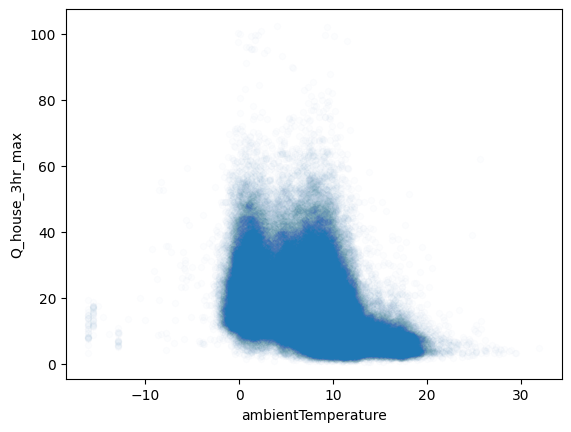

In [8]:
df_cics.plot(kind='scatter', y='Q_house_3hr_max', x='ambientTemperature', alpha=0.01)

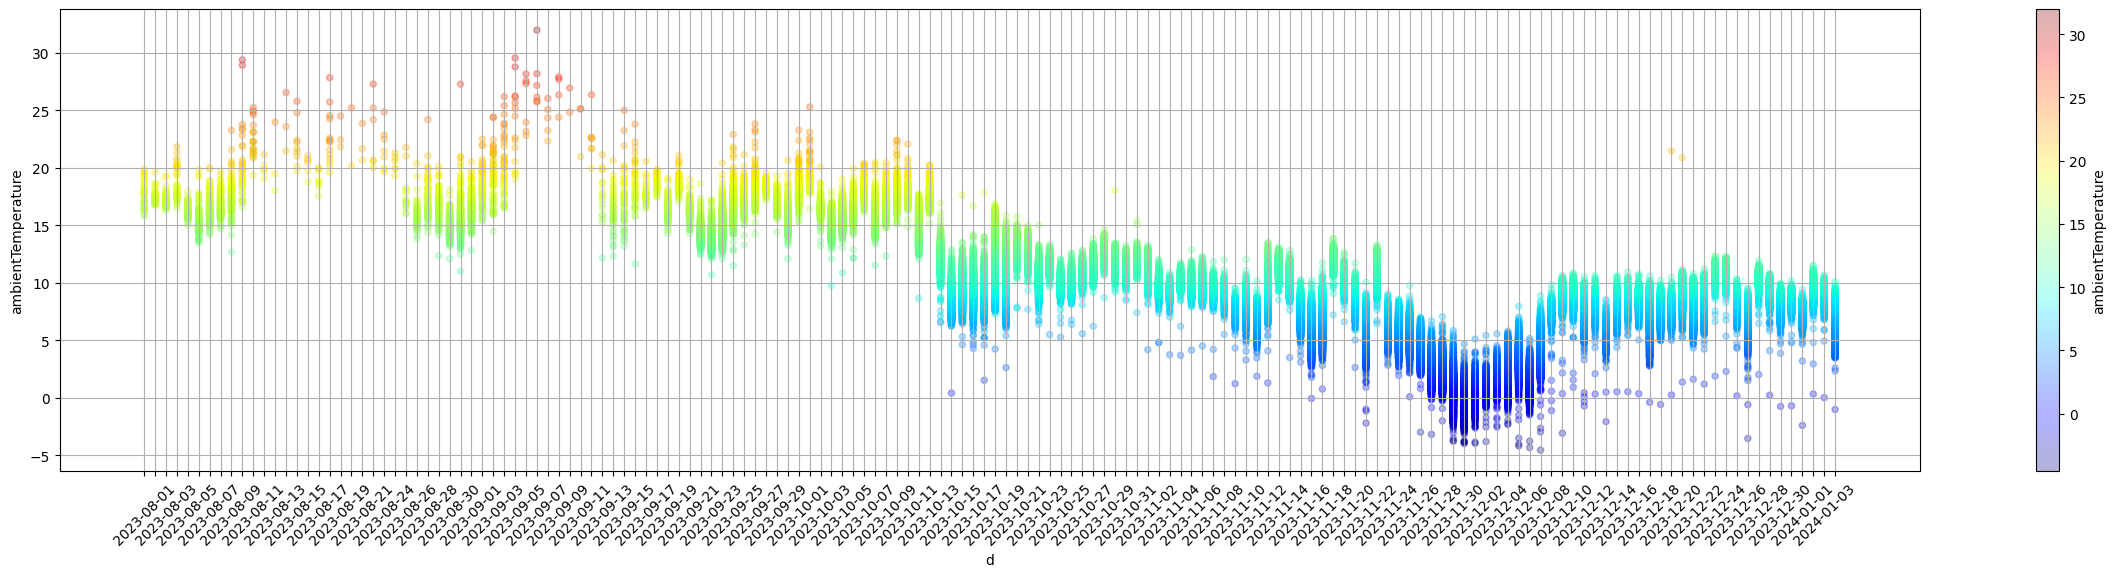

In [112]:
# df_cics['dm'] = df_cics['d'].dt.strftime('%m-%d')
df_cics.sort_values(by='d', inplace=True)
ax = df_cics.plot(kind='scatter', y='ambientTemperature', x='d', figsize=[30, 6], c='ambientTemperature', cmap='jet', rot=45, alpha=0.3, grid=True)

# Customizing to show every other label
labels = ax.get_xticklabels()
for i, label in enumerate(labels):
    if i % 2 != 0:  # Hide every other label
        label.set_visible(False)

plt.show()

### back to normal

In [224]:
print(f"Number of CiCs: {len(df_cics['clientid'].unique())}")
print(f"Number of rows: {len(df_cics.index)}")

# Clean up and pre-process data

# rename clientid to cic_id
df_cics.rename(columns={'clientid': 'cic_id'}, inplace=True)

# Remove outliers from Q_hp1, Q_hp2, E_hp1, E_hp2
# TO DO: ADAPT CODE TO FILTER BOTH ON 24HR AND 3HR DATA
max_Q_hp = 8 # kWh
max_E_hp = 3 # kWh
max_Q_cv = 37 # kWh
df_cics = df_cics[
    (df_cics['Q_hp1'] < 24 * max_Q_hp) & (df_cics['Q_hp2'] < 24 * max_Q_hp) & 
    (df_cics['E_hp1'] < 24 * max_E_hp) & (df_cics['E_hp2'] < 24 * max_E_hp) &
    (df_cics['Q_cv'] < 24 * max_Q_cv)
].copy()
print(f"Number of rows after removing outliers: {len(df_cics.index)}")

# Remove days when CiC was in LTE mode
df_cics.dropna(subset=['ambientTemperature', 'supplyTemperature', 'roomTemperatureError', 'roomSetTemperature', 'roomTemperature'], inplace=True)
print(f"Number of rows after removing days when CiC was in LTE mode: {len(df_cics.index)}")

# Remove rows of cic's that have less than 10 days of data
df_cics = df_cics.groupby('cic_id').filter(lambda x: len(x.index) >= 10)
print(f"Number of rows after removing cic's with less than 10 days of data: {len(df_cics.index)}")


Number of CiCs: 100
Number of rows: 8601
Number of rows after removing outliers: 8547
Number of rows after removing days when CiC was in LTE mode: 8218
Number of rows after removing cic's with less than 10 days of data: 8218


In [68]:
# Mark outliers for determining heat demand curve and supply temperature curve

# per cic mark water outliers and 
df_cics['water_outlier'] = 0
df_cics['heat_outlier'] = 0

# errors during outlier detection
errors = []


for cic in df_cics['cic_id'].unique():
    df_cic = df_cics[df_cics['cic_id'] == cic]

    try: 
        X = df_cic[['Q_hp', 'Q_house']].to_numpy()
        model = CD(contamination=FWFM())
        model.fit(X)
        y_pred = model.predict(X)
        # set y-pred back into original df
        df_cics.loc[df_cics['cic_id'] == cic,'heat_outlier'] = y_pred
    except ValueError:
        errors.append(cic)
        pass
    
    # try: 
    #     X = df_cic[['ambientTemperature', 'supplyTemperature']].to_numpy()
    #     model = CD(contamination=FWFM())
    #     model.fit(X)
    #     y_pred = model.predict(X)
    #     df_cics.loc[df_cics['cic_id'] == cic,'water_outlier'] = y_pred
    # except ValueError:
    #     pass

/Users/noutneijmeijer/Documents/quatt_data_analysis/.venv/lib/python3.11/site-packages/pyod/models/cd.py:52: RuntimeWarning: invalid value encountered in divide
  residuals_studentized = residuals / np.sqrt(mse) / np.sqrt(
/Users/noutneijmeijer/Documents/quatt_data_analysis/.venv/lib/python3.11/site-packages/pyod/models/cd.py:52: RuntimeWarning: invalid value encountered in divide
  residuals_studentized = residuals / np.sqrt(mse) / np.sqrt(
/Users/noutneijmeijer/Documents/quatt_data_analysis/.venv/lib/python3.11/site-packages/pyod/models/cd.py:101: RuntimeWarning: Mean of empty slice
  distances_ = np.nanmean(distances_, axis=0)


In [72]:
df_cics['cv_ratio'] = df_cics['Q_cv'] / df_cics['Q_house']

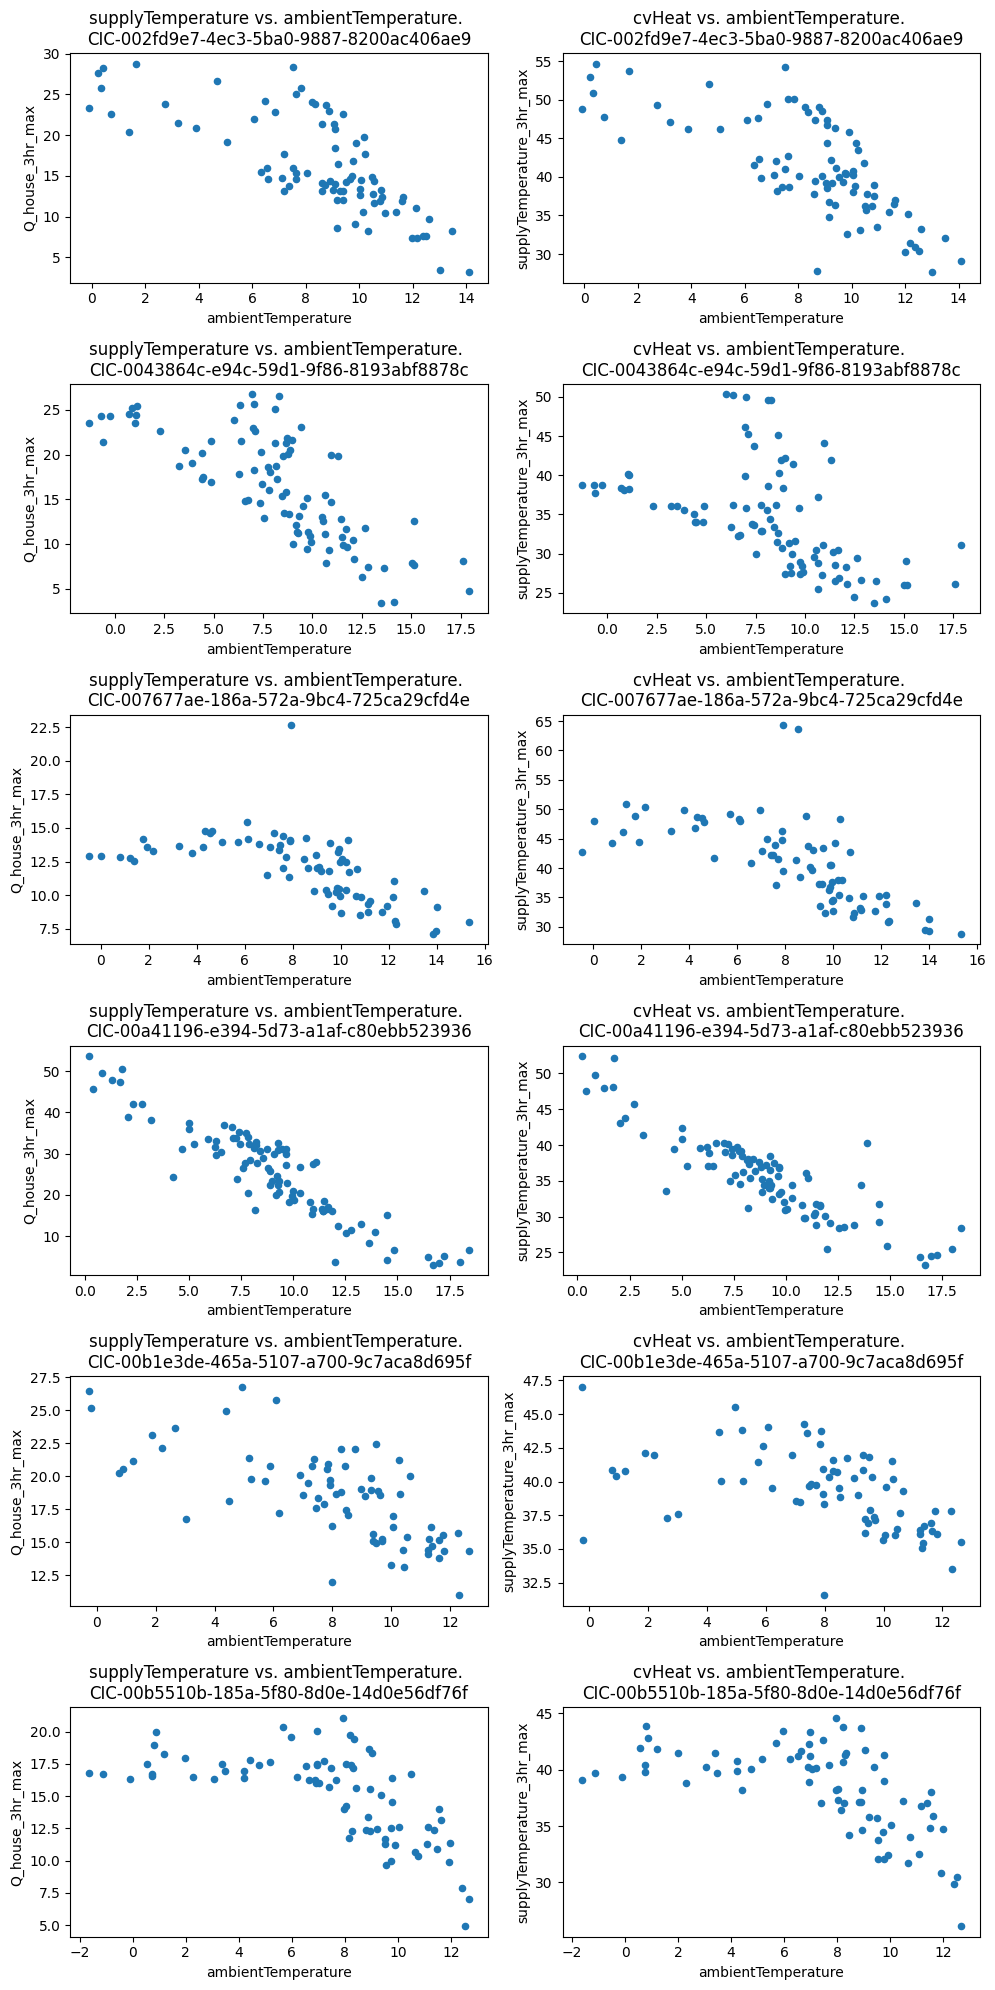

In [287]:
# plot supplyTemperature vs. ambientTemperature for several cic's
import seaborn as sns
import matplotlib.pyplot as plt
cics = df_cics['cic_id'].unique()

fig, axs = plt.subplots(6, 2, figsize=(10, 20))
axs = axs.flatten()  # Flatten the array of axes to easily iterate over it

for i, cic in enumerate(cics[:6]):  # Change the slice to select the first 6 cics
    df_cic = df_cics[df_cics['cic_id'] == cics[i+6]]
    df_cic.plot(kind='scatter', x='ambientTemperature', y='Q_house_3hr_max', 
                # c='heat_outlier', cmap='jet', 
                ax=axs[i*2], label=cic)
    axs[i*2].set_title(f'supplyTemperature vs. ambientTemperature. \n{cic}')
    axs[i*2].get_legend().remove()

    df_cic.plot(kind='scatter', x='ambientTemperature', y='supplyTemperature_3hr_max', 
                 ax=axs[i*2+1], label=cic)
    axs[i*2+1].set_title(f'cvHeat vs. ambientTemperature. \n{cic}')
    axs[i*2+1].get_legend().remove()
    # axs[i].collections[0].colorbar.remove()


plt.tight_layout()  # Adjust the layout so that the plots do not overlap
plt.show()



# fig = go.Figure()
# for cic in cics[:5]:
#     df_cic = df_cics[df_cics['cic_id'] == cic]
#     fig.add_trace(go.Scatter(x=df_cic['ambientTemperature'], y=df_cic['supplyTemperature'], mode='markers', name=cic))
# fig.update_layout(title='supplyTemperature vs. ambientTemperature for several cic\'s')
# fig.show()

In [288]:
df_cics.columns

Index(['cic_id', 'd', 'ambientTemperature', 'supplyTemperature',
       'supplyTemperatureOos', 'roomTemperatureError', 'roomSetTemperature',
       'roomTemperature', 'Q_hp_24hr', 'Q_hp1_24hr', 'Q_hp2_24hr', 'E_hp_24hr',
       'E_hp1_24hr', 'E_hp2_24hr', 'Q_cv_24hr', 'Q_house_24hr', 'hpHeatRatio',
       'COP', 'h_3hr_max', 'Q_house_3hr_max', 'Q_hp_3hr_max', 'Q_hp1_3hr_max',
       'Q_hp2_3hr_max', 'E_hp_3hr_max', 'E_hp1_3hr_max', 'E_hp2_3hr_max',
       'Q_cv_3hr_max', 'hpHeatRatio_3hr_max', 'COP_3hr_max',
       'supplyTemperature_3hr_max'],
      dtype='object')

/var/folders/0m/6_0b79q57177vdz5tjzlnt1w0000gn/T/ipykernel_86852/2465185769.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cic['residuals'] = abs(df_cic['supplyTemperature_3hr_max'] - model.predict(df_cic[['ambientTemperature']]))
/var/folders/0m/6_0b79q57177vdz5tjzlnt1w0000gn/T/ipykernel_86852/2465185769.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cic['residuals_rel'] = df_cic['residuals'] / df_cic['residuals'].std()
/var/folders/0m/6_0b79q57177vdz5tjzlnt1w0000gn/T/ipykernel_86852/2465

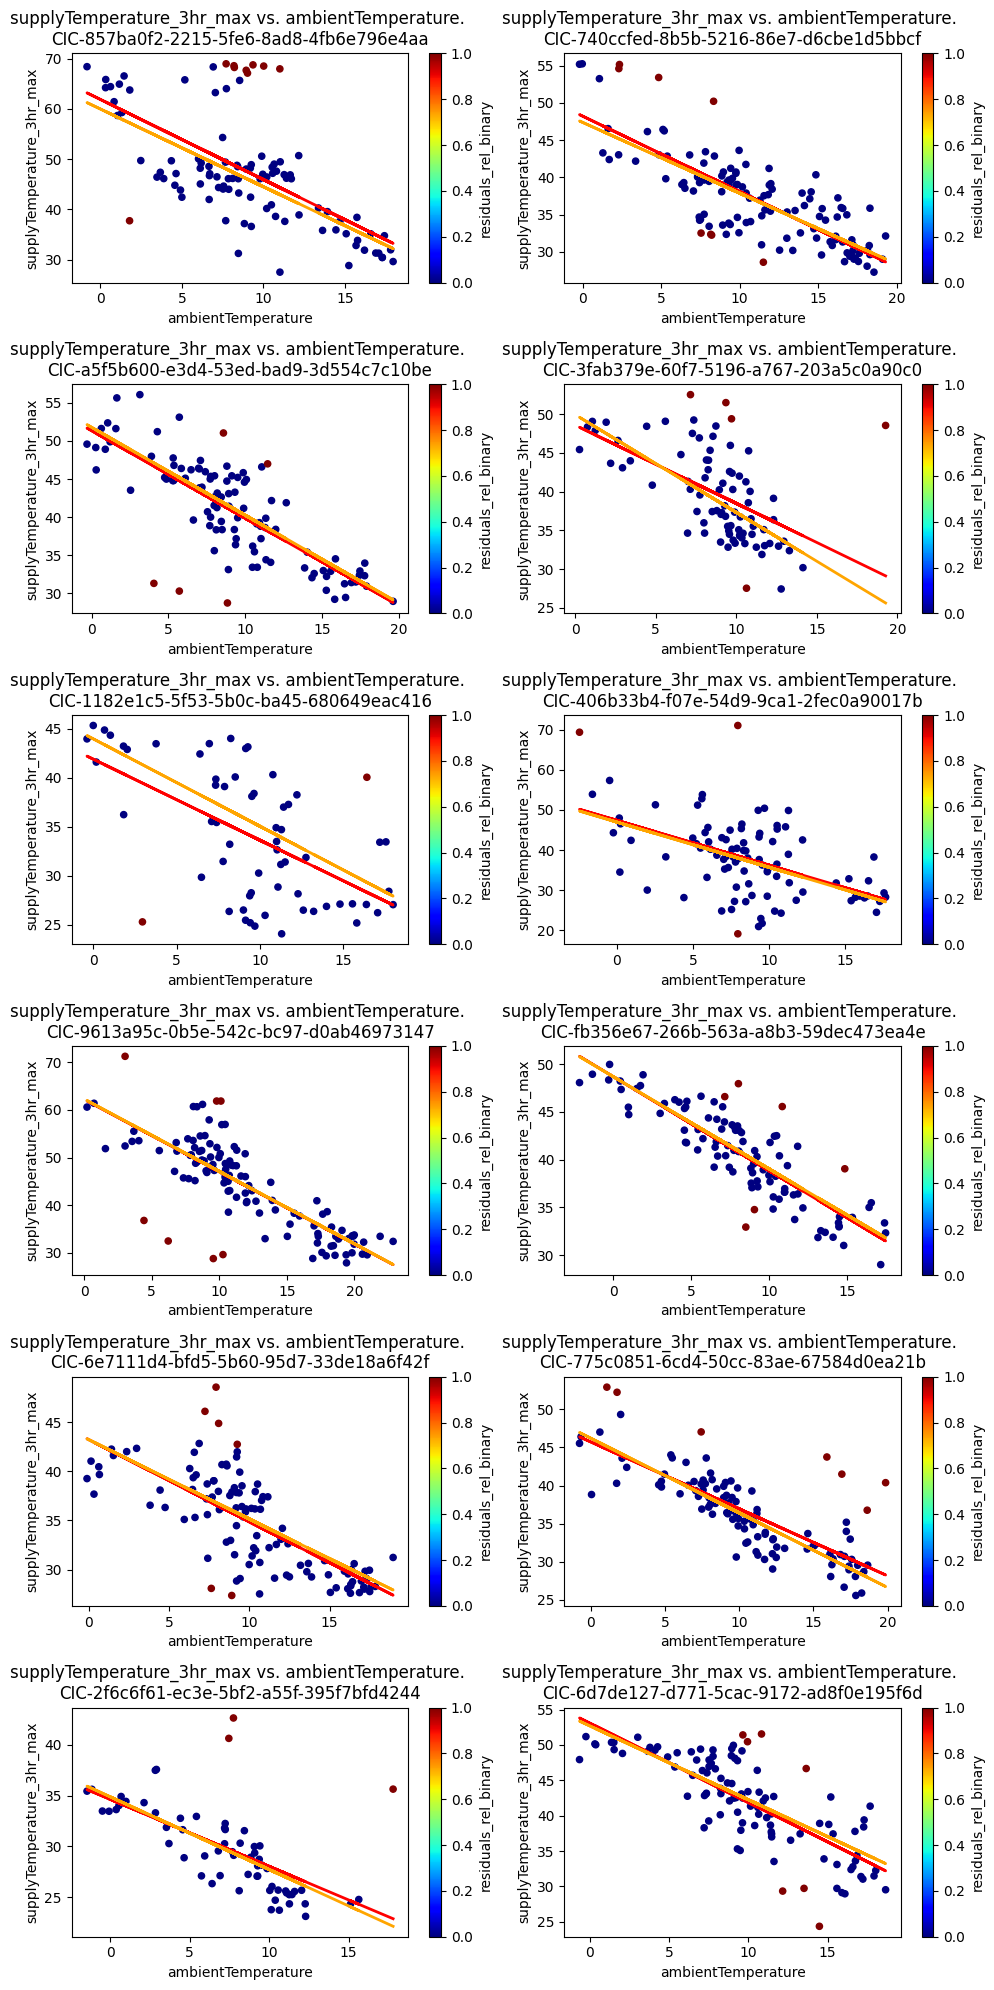

In [117]:
cics = df_cics['cic_id'].unique()
model = LinearRegression()

fig, axs = plt.subplots(6, 2, figsize=(10, 20))
axs = axs.flatten()  # Flatten the array of axes to easily iterate over it

for i, cic in enumerate(cics[:12]):  # Change the slice to select the first 6 cics
    i+12
    df_cic = df_cics[df_cics['cic_id'] == cic]


    model.fit(df_cic[['ambientTemperature']], df_cic['supplyTemperature_3hr_max'])
    # absoluate error
    df_cic['residuals'] = abs(df_cic['supplyTemperature_3hr_max'] - model.predict(df_cic[['ambientTemperature']]))
    df_cic['residuals_rel'] = df_cic['residuals'] / df_cic['residuals'].std()
    df_cic['residuals_rel_binary'] = np.where(df_cic['residuals_rel'] > 3, 1, 0)
    df_cic.plot(kind='scatter', x='ambientTemperature', y='supplyTemperature_3hr_max',
                c='residuals_rel_binary', cmap='jet', ax=axs[i], label=cic)
    
    # plot linear regression line
    axs[i].plot(df_cic['ambientTemperature'], model.predict(df_cic[['ambientTemperature']]), color='red', linewidth=2)

    TSModel = TheilSenRegressor(random_state=0).fit(df_cic[['ambientTemperature']], df_cic['supplyTemperature_3hr_max'])
    axs[i].plot(df_cic['ambientTemperature'], TSModel.predict(df_cic[['ambientTemperature']]), color='orange', linewidth=2)

    if TSModel.coef_ > 0:
        axs[i].axhline(y=df_cic['supplyTemperature_3hr_max'].quantile(0.8), color='green', linestyle='--')

    axs[i].set_title(f'supplyTemperature_3hr_max vs. ambientTemperature. \n{cic}')
    axs[i].get_legend().remove()
    # axs[i].collections[0].colorbar.remove()


plt.tight_layout()  # Adjust the layout so that the plots do not overlap
plt.show()


In [60]:
import random

In [126]:
def fit_model(df, x_col, y_col):
    model = TheilSenRegressor(random_state=0)
    
    if len(df_cic.index) >= 10:
        X = df[x_col].to_numpy().reshape(-1, 1)
        y = df[y_col].to_numpy()
        model.fit(X, y)
        rmse = mean_squared_error(y, model.predict(X), squared=False)
        
        return model.coef_[0], model.intercept_, rmse, len(df)
    else:
        return np.nan, np.nan, np.nan

def create_df(df, cic_ids, column_pairs):
    df_train = pd.DataFrame(columns=['cic_id'] + [f'{x}_{y}_{stat}' for x, y in column_pairs for stat in ['slope', 'intercept', 'rmse']])
    df_train['cic_id'] = cic_ids
    
    for cic_id in cic_ids:
        for x_col, y_col in column_pairs:
            slope, intercept, rmse = fit_model(df, x_col, y_col, cic_id)
            df_train.loc[df_train['cic_id'] == cic_id, f'{x_col}_{y_col}_slope'] = slope
            df_train.loc[df_train['cic_id'] == cic_id, f'{x_col}_{y_col}_intercept'] = intercept
            df_train.loc[df_train['cic_id'] == cic_id, f'{x_col}_{y_col}_rmse'] = rmse
    
    return df_train

# Define the cic_ids and column pairs
cic_ids = random.sample(df_cics['cic_id'].unique().tolist(), 100)
# take a random sample of 100 cic's out of cic_ids

model_list = [{'colname': 'supplyTemperature', 'name':'tw_24'},
            {'colname': 'Q_house_24hr', 'name':'Q_24'},
            {'colname': 'supplyTemperature_3hr_max', 'name':'tw_3', 'filter':'ambientTemperature<7'},
            {'colname': 'Q_house_3hr_max', 'name':'Q_3'}]

# Create the DataFrame
df_cic_models = pd.DataFrame(columns=[
    'cic_id',
    'tw_24_slope', 'tw_24_intercept', 'tw_24_rmse', 'tw_24_n',
    'Q_24_slope', 'Q_24_intercept', 'Q_24_rmse', 'Q_24_n',
    'tw_3_slope', 'tw_3_intercept', 'tw_3_rmse', 'tw_3_n',
    'Q_3_slope', 'Q_3_intercept', 'Q_3_rmse', 'Q_3_n'
    ])
df_cic_models['cic_id'] = cic_ids

for cic in cic_ids:
    df_cic = df_cics[df_cics['cic_id']==cic]

    for model in model_list:
        if 'filter' in model:
            slope, intercept, rmse, n = fit_model(df_cic.query(model['filter']),
                                                  'ambientTemperature',
                                                  model['colname'])
        else:
            slope, intercept, rmse, n = fit_model(df_cic,
                                                  'ambientTemperature', 
                                                  model['colname'])

        df_cic_models.loc[df_cic_models['cic_id'] == cic, f'{model["name"]}_slope'] = slope
        df_cic_models.loc[df_cic_models['cic_id'] == cic, f'{model["name"]}_intercept'] = intercept
        df_cic_models.loc[df_cic_models['cic_id'] == cic, f'{model["name"]}_rmse'] = rmse
        df_cic_models.loc[df_cic_models['cic_id'] == cic, f'{model["name"]}_n'] = n



#create_df(df_cics, random.sample(cic_ids.tolist(), 100), column_pairs)

In [127]:
df_cic_models

,cic_id,tw_24_slope,tw_24_intercept,tw_24_rmse,tw_24_n,Q_24_slope,Q_24_intercept,Q_24_rmse,Q_24_n,tw_3_slope,tw_3_intercept,tw_3_rmse,tw_3_n,Q_3_slope,Q_3_intercept,Q_3_rmse,Q_3_n
0,CIC-fd3f4664-c925-56a3-be2a-4bedd5d141a9,-0.506356,32.300322,3.96036,81,-4.985609,101.174095,17.932683,81,-2.708459,47.269335,3.950354,21,-1.629818,29.48655,7.893719,81
1,CIC-34acae10-24e4-5a51-b578-0ca06a88c936,0.022469,40.019726,4.422822,81,-3.935669,74.822896,8.684764,81,-0.330647,49.197908,3.802683,18,-0.493673,13.477208,1.592499,81
2,CIC-07d02a5f-18f0-5bb6-a51f-a4f39af13616,-0.693854,43.842154,2.13153,85,-6.283425,112.814387,12.536971,85,-1.047071,47.914808,2.819815,28,-0.814544,22.438836,1.920441,85
3,CIC-53a66115-bdcf-5ab2-a7fd-5819f7153698,-0.501963,29.306524,0.827756,82,-4.815389,84.481266,10.943518,82,-0.460254,30.591898,0.787467,28,-0.445232,14.84075,1.328617,82
4,CIC-dc02a5a5-ddbd-5cdf-a055-0fc0b4b1fca5,-0.503726,35.967971,2.235714,82,-5.36575,87.224936,11.579026,82,-2.353887,53.8191,5.596664,22,-0.95525,19.39627,4.04438,82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,CIC-fd87734e-1c13-5b4c-86a5-cff6db08bd70,-2.01108,56.949827,2.801837,65,-11.873833,179.414715,14.177927,65,0.16697,57.909351,0.416811,13,-2.885665,47.539037,6.69547,65
96,CIC-d9a3b118-b126-52c1-a8fa-708223054123,-0.321057,39.979944,6.253415,62,-2.781283,54.837073,14.35742,62,0.085591,44.185558,8.031424,28,-0.376399,11.245099,2.781174,62
97,CIC-d8b3fd75-8914-5a5c-8af1-9b8b46251c02,-0.387251,32.806221,1.59669,79,-3.742273,54.384772,6.24332,79,-0.415449,39.217008,1.846968,20,-0.578292,14.212158,1.744187,79
98,CIC-fa5f1076-44d8-53f4-970d-7bcfdd52c29f,-0.59546,36.080283,2.311136,73,-7.798407,157.08686,21.01963,73,-1.805652,49.680578,3.798171,21,-1.558019,34.089305,5.608779,73


In [102]:
# create a dataframe with one row per cic id
df_cics_train = pd.DataFrame(columns=['cic_id',
                                      'water_slope',
                                      'water_intercept', 
                                      'water_rmse',
                                      'n_wt',
                                      'heat_slope',
                                      'heat_intercept',
                                      'heat_rmse',
                                      'n_hd'])

# create a column with each unique cic id
df_cics_train['cic_id'] = random.sample(df_cics['cic_id'].unique().tolist(), 1000)


# make an skLearn linear regression model
model = TheilSenRegressor(random_state=0)

for cic in df_cics_train['cic_id']:
    # apply linearRegression model to each cic
    df_cic_wt = df_cics[(df_cics['cic_id'] == cic)]
    
    # fit the model for T water 24hr
    if len(df_cic_wt.index) >= 10:
        model.fit(df_cic_wt[['ambientTemperature']], df_cic_wt['supplyTemperature'])

        rmse_w = mean_squared_error(df_cic_wt['supplyTemperature'], 
                                model.predict(df_cic_wt[['ambientTemperature']]),
                                squared=False)
        # add values to dataframe
        if model.coef_ > 0:
            df_cics_train.loc[df_cics_train['cic_id'] == cic, 'water_slope'] = 0
            df_cics_train.loc[df_cics_train['cic_id'] == cic, 'water_intercept'] = df_cic_wt['supplyTemperature'].quantile(0.8)
        else:
            df_cics_train.loc[df_cics_train['cic_id'] == cic, 'water_slope'] = model.coef_[0]
            df_cics_train.loc[df_cics_train['cic_id'] == cic, 'water_intercept'] = model.intercept_
        df_cics_train.loc[df_cics_train['cic_id'] == cic, 'water_rmse'] = rmse_w
        df_cics_train.loc[df_cics_train['cic_id'] == cic, 'n_wt'] = len(df_cic_wt.index)

    # fit model for Q house 24 hr
    df_cic_hd = df_cics[(df_cics['cic_id'] == cic)] #& (df_cics['heat_outlier'] == 0)]
    if len(df_cic_hd.index) >= 10:
        X = df_cic_hd['ambientTemperature'].to_numpy().reshape(-1, 1)
        y = df_cic_hd['Q_house_24hr'].to_numpy()
        modelHeatDemand = TheilSenRegressor(random_state=0).fit(X, y)
        rmse_h = mean_squared_error(df_cic_hd['Q_house_24hr'], 
                                modelHeatDemand.predict(df_cic_hd[['ambientTemperature']]), 
                                squared=False)

        
        # add values to dataframe
        df_cics_train.loc[df_cics_train['cic_id'] == cic, 'heat_slope'] = list(modelHeatDemand.coef_)[0]
        df_cics_train.loc[df_cics_train['cic_id'] == cic, 'heat_intercept'] = modelHeatDemand.intercept_
        df_cics_train.loc[df_cics_train['cic_id'] == cic, 'heat_rmse'] = rmse_h
        df_cics_train.loc[df_cics_train['cic_id'] == cic, 'n_hd'] = len(df_cic_hd.index)

    # fit the model for T water 24hr
    # apply linearRegression model to each cic
    df_cic_wt = df_cics[(df_cics['cic_id'] == cic) & (df_cics['ambientTemperature']<7)]
    if len(df_cic_wt.index) >= 10:
        model.fit(df_cic_wt[['ambientTemperature']], df_cic_wt['supplyTemperature_3hr_max'])

        rmse_w = mean_squared_error(df_cic_wt['supplyTemperature_3hr_max'], 
                                model.predict(df_cic_wt[['ambientTemperature']]),
                                squared=False)
        # add values to dataframe
        if model.coef_ > 0:
            df_cics_train.loc[df_cics_train['cic_id'] == cic, 'water_slope_3hr'] = 0
            df_cics_train.loc[df_cics_train['cic_id'] == cic, 'water_intercept_3hr'] = df_cic_wt['supplyTemperature_3hr_max'].quantile(0.8)
        else:
            df_cics_train.loc[df_cics_train['cic_id'] == cic, 'water_slope_3hr'] = model.coef_[0]
            df_cics_train.loc[df_cics_train['cic_id'] == cic, 'water_intercept_3hr'] = model.intercept_
        df_cics_train.loc[df_cics_train['cic_id'] == cic, 'water_rmse_3hr'] = rmse_w
        df_cics_train.loc[df_cics_train['cic_id'] == cic, 'n_wt_3hr'] = len(df_cic_wt.index)


    df_cic_hd = df_cics[(df_cics['cic_id'] == cic)] #& (df_cics['heat_outlier'] == 0)]
    if len(df_cic_hd.index) >= 10:
        X = df_cic_hd['ambientTemperature'].to_numpy().reshape(-1, 1)
        y = df_cic_hd['Q_house_3hr_max'].to_numpy()
        modelHeatDemand = TheilSenRegressor(random_state=0).fit(X, y)
        rmse_h = mean_squared_error(df_cic_hd['Q_house_3hr_max'], 
                                modelHeatDemand.predict(df_cic_hd[['ambientTemperature']]), 
                                squared=False)

        # add values to dataframe
        df_cics_train.loc[df_cics_train['cic_id'] == cic, 'heat_slope_3hr'] = list(modelHeatDemand.coef_)[0]
        df_cics_train.loc[df_cics_train['cic_id'] == cic, 'heat_intercept_3hr'] = modelHeatDemand.intercept_
        df_cics_train.loc[df_cics_train['cic_id'] == cic, 'heat_rmse_3hr'] = rmse_h
        df_cics_train.loc[df_cics_train['cic_id'] == cic, 'n_hd_3hr'] = len(df_cic_hd.index)


/Users/noutneijmeijer/Documents/quatt_data_analysis/.venv/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but TheilSenRegressor was fitted without feature names
  warnings.warn(
/Users/noutneijmeijer/Documents/quatt_data_analysis/.venv/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but TheilSenRegressor was fitted without feature names
  warnings.warn(
/Users/noutneijmeijer/Documents/quatt_data_analysis/.venv/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but TheilSenRegressor was fitted without feature names
  warnings.warn(
/Users/noutneijmeijer/Documents/quatt_data_analysis/.venv/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but TheilSenRegressor was fitted without feature names
  warnings.warn(
/Users/noutneijmeijer/Documents/quatt_data_analysis/.venv/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, bu

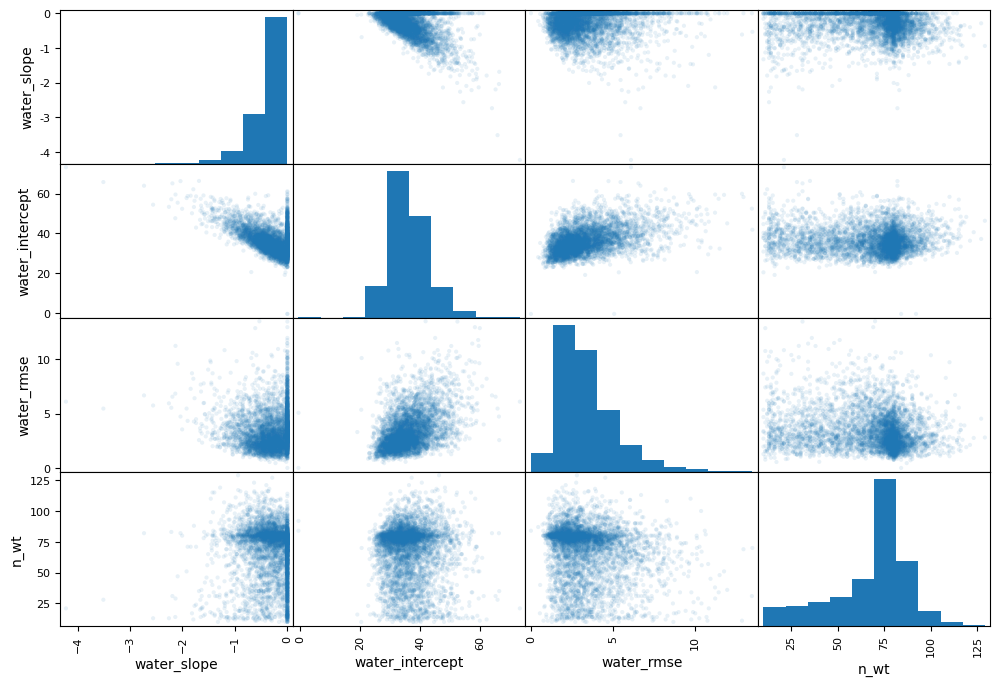

In [83]:
# change all columns in df_cics_train to numerical
df_cics_train = df_cics_train.apply(pd.to_numeric, errors='ignore')

# scatter plot each of three added columns of df_cics_train
from pandas.plotting import scatter_matrix

attributes = ["water_slope", 'water_intercept', 'water_rmse', 'n_wt']
scatter_matrix(df_cics_train[attributes], figsize=(12, 8), alpha=0.1)
plt.show()




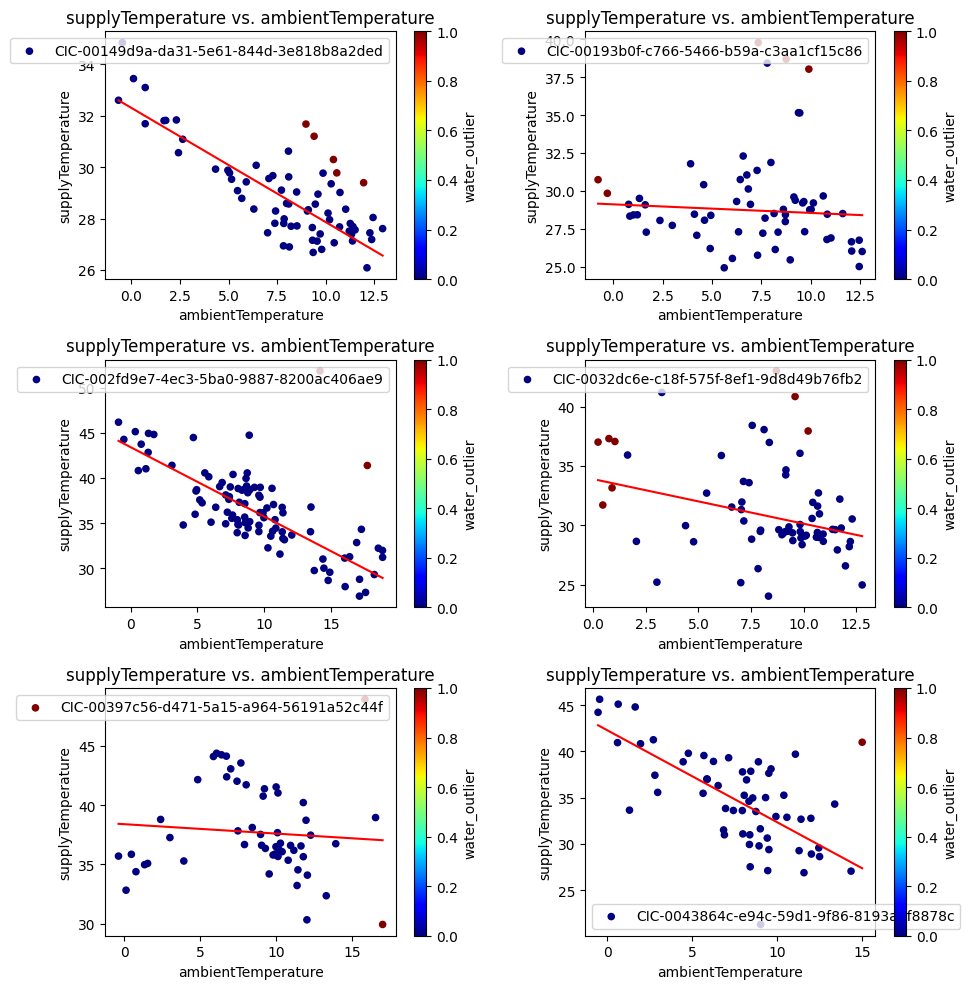

In [112]:
# plot supplyTemperature vs. ambientTemperature for several cic's using seaborn
import seaborn as sns
import matplotlib.pyplot as plt
cics = df_cics['cic_id'].unique()

fig, axs = plt.subplots(3, 2, figsize=(10, 10))
axs = axs.flatten()  # Flatten the array of axes to easily iterate over it

for i, cic in enumerate(cics[:6]):  # Change the slice to select the first 6 cics
    df_cic = df_cics[df_cics['cic_id'] == cic]
    df_cic.plot(kind='scatter', x='ambientTemperature', y='supplyTemperature', 
                c='water_outlier', cmap='jet', ax=axs[i], label=cic)
    axs[i].set_title(f'supplyTemperature vs. ambientTemperature')
    # axs[i].set_suptitle(cic)
    axs[i].legend()
    # add line based on linear regression model
    x = np.linspace(df_cic['ambientTemperature'].min(), df_cic['ambientTemperature'].max(), 100)
    y = df_cics_train[df_cics_train['cic_id'] == cic]['water_slope'].values[0] * x + df_cics_train[df_cics_train['cic_id'] == cic]['water_intercept'].values[0]
    axs[i].plot(x, y, '-r')

plt.tight_layout()  # Adjust the layout so that the plots do not overlap
plt.show()



## Extrapolate to -10 and -5 and 0 degrees

From [google sheet](https://docs.google.com/spreadsheets/d/15kTyQeI37S-ABCxKRoklAmAvpKCPe6Ss/edit#gid=177825386).  
At -7 degrees, for a 4kW unit:  
- supplyTemperature = 35, Pmax = 4.748 (90 Hz), Qmax = 113.952
- supplyTemperature = 45, Pmax = 3.627 (90 Hz), Qmax = 87.048
- supplyTemperature = 55, Pmax = 3.360 (84 Hz), Qmax = 80.64
- electricalHeater of boiler of 2kW -> Qmax += 48

At -7 degrees, for an 8kW unit:
- supplyTemperature = 35, Pmax = 8.375 = 3.980 + 4.748 (79 Hz & 90 Hz), Qmax = 201
- supplyTemperature = 45, Pmax = 6.739 = 3.11 + 3.627 (79Hz & 90 Hz), Qmax = 161.75
- supplyTemperature = 55, Pmax = 6.40 = 3.04 * 3.360 (79Hz & 84 Hz), Qmax = 153.62
- electricalHeater of boiler of 2kW -> Qmax += 48


single_hybrid_limits = [4.748, 3.627, 3.360]
double_hybrid_limits = [8.375, 6.739, 6.40]

In [105]:
# calculate heat demand and water supply temperature for each cic
temperature = -7
df_results = pd.DataFrame(columns=['cic_id','heat_demand','supply_temperature'])

# only cic's where heat demand goes up as temperature goes down
df_results['cic_id'] = df_cics_train[(df_cics_train['heat_slope']<0) & (df_cics_train['water_slope'].notna())]['cic_id'].unique()


df_results['heat_demand'] = df_results['cic_id'].apply(lambda x: heat_demand_model(temperature, 
                                                                                    df_cics_train[df_cics_train['cic_id'] == x]['heat_slope'].values[0], 
                                                                                    df_cics_train[df_cics_train['cic_id'] == x]['heat_intercept'].values[0]))
df_results['supply_temperature'] = df_results['cic_id'].apply(lambda x: heat_demand_model(temperature,
                                                                                          df_cics_train[df_cics_train['cic_id'] == x]['water_slope'].values[0], 
                                                                                        df_cics_train[df_cics_train['cic_id'] == x]['water_intercept'].values[0]))

df_results['heat_demand_3hr'] = df_results['cic_id'].apply(lambda x: heat_demand_model(temperature, 
                                                                                    df_cics_train[df_cics_train['cic_id'] == x]['heat_slope_3hr'].values[0], 
                                                                                    df_cics_train[df_cics_train['cic_id'] == x]['heat_intercept_3hr'].values[0]))
df_results['supply_temperature_3hr'] = df_results['cic_id'].apply(lambda x: heat_demand_model(temperature,
                                                                                          df_cics_train[df_cics_train['cic_id'] == x]['water_slope_3hr'].values[0], 
                                                                                        df_cics_train[df_cics_train['cic_id'] == x]['water_intercept_3hr'].values[0]))

In [90]:
shl = single_hybrid_limits = [4.748, 3.627, 3.360]
dhl = double_hybrid_limits = [8.375, 6.739, 6.40]

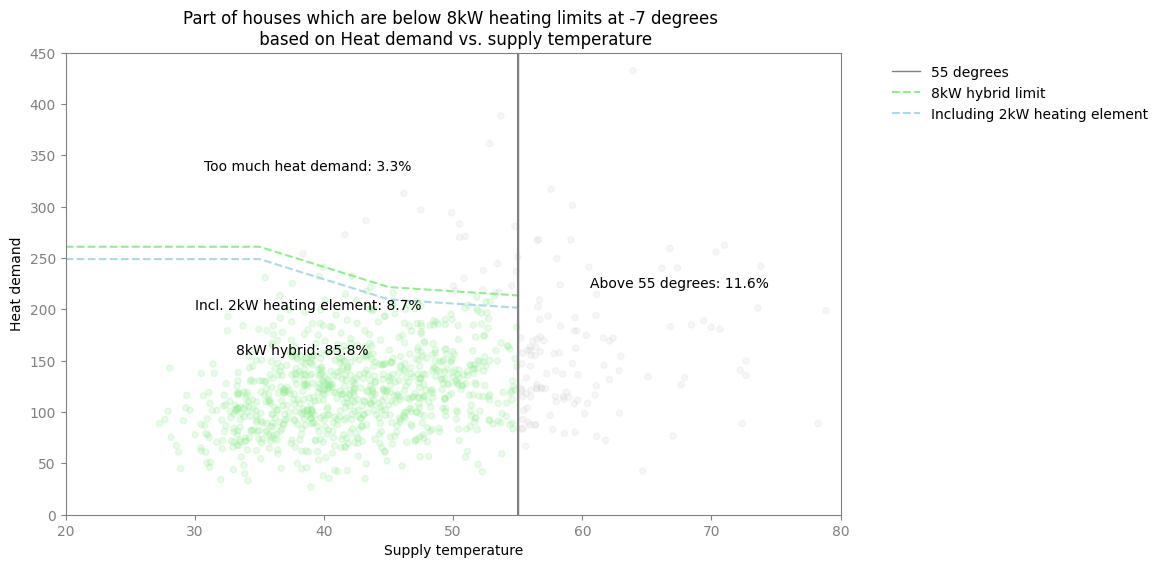

In [106]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection


# possible polygon 1 hp
hrs = 24
polygons = [
    {'x':[20, 35, 45, 55, 55, 20], 'y': [hrs*dhl[0], hrs*dhl[0], hrs*dhl[1], hrs*dhl[2], 0, 0], 'color': 'lightgreen', 'label': '8kW hybrid', 'id': 1},
    {'x':[20, 35, 45, 55, 55, 45, 35, 20], 'y': [249, 249, 209.75, 201.62, 153.62, 161.75, 201, 201], 'color': 'lightblue', 'label': 'Incl. 2kW heating element', 'id': 2},
    {'x':[55, 55, 80, 80], 'y': [0, 450, 450, 0], 'color': 'lightgrey', 'label': 'Above 55 degrees', 'id': 3},
    {'x':[20, 35, 45, 55, 55, 45, 35, 20], 'y': [450, 450, 450, 450, 201.62, 209.75, 249, 249], 'color': 'lightgrey', 'label': 'Too much heat demand','id':4},
]

# create a function that checks whether a point is inside a polygon
def point_in_polygon(point, polygon):
    return Polygon(polygon).contains_point(point)

# plot results
df_results['colors'] = df_results.apply(lambda row: next((polygon['color'] for polygon in polygons if point_in_polygon((row['supply_temperature'], row['heat_demand']), list(zip(polygon['x'], polygon['y'])))), None), axis=1)
df_results[df_results['colors'].notna()].plot(
    kind='scatter', x='supply_temperature', y='heat_demand', 
    alpha=0.2, 
    c=df_results[df_results['colors'].notna()]['colors'].tolist(),
    figsize=(10, 6)
)

for polygon in polygons:
    points_in_polygon = df_results.apply(lambda row: point_in_polygon((row['supply_temperature'], row['heat_demand']), list(zip(polygon['x'], polygon['y']))), axis=1)
    percentage = points_in_polygon.sum() / len(df_results) * 100
    plt.text(sum(polygon['x'])/len(polygon['x']), sum(polygon['y'])/len(polygon['y']), f'{polygon["label"]}: {percentage:.1f}%', horizontalalignment='center', verticalalignment='center')

# lines seperating different polygons
plt.axvline(x=55, color='grey', label='55 degrees',linewidth=1)
plt.plot(polygons[0]['x'][:4], polygons[0]['y'][:4], color=polygons[0]['color'], linestyle='--', label='8kW hybrid limit')
plt.plot(polygons[1]['x'][:4], polygons[1]['y'][:4], color=polygons[1]['color'], linestyle='--', label='Including 2kW heating element')


plt.title('Part of houses which are below 8kW heating limits at -7 degrees \n based on Heat demand vs. supply temperature')
plt.xlabel('Supply temperature')
plt.xlim(20, 80)
plt.ylim(0, 450)
plt.ylabel('Heat demand')
# plt.grid()


ax = plt.gca()
ax.tick_params(axis='x', colors='grey')
ax.tick_params(axis='y', colors='grey')
ax.spines[['bottom','left','right','top']].set_color('grey')

# add legend
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), frameon=False)

# plot vertical line at 55 degrees in grey
plt.axvline(x=55, color='grey')

plt.show()

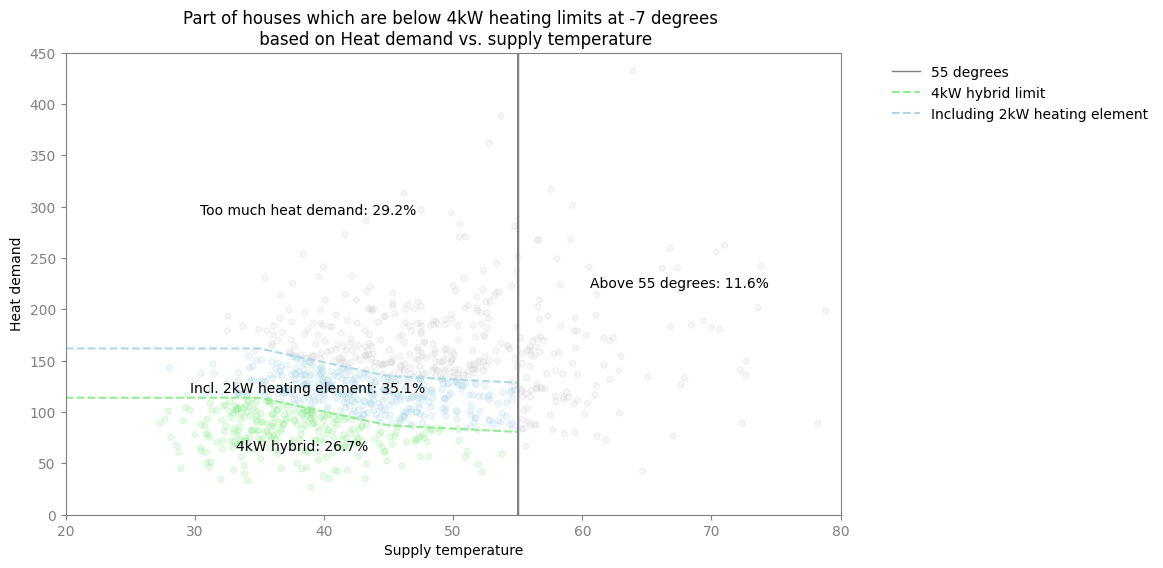

In [107]:
# possible polygon 2 hp
polygons = [
    {'x':[20, 35, 45, 55, 55, 20], 'y': [113.952, 113.952, 87.048, 80.64, 0, 0], 'color': 'lightgreen', 'label': '4kW hybrid', 'id': 1},
    {'x':[20, 35, 45, 55, 55, 45, 35, 20], 'y': [161.952, 161.952, 135.048, 128.64, 80.64, 87.048, 113.952, 113.952], 'color': 'lightblue', 'label': 'Incl. 2kW heating element', 'id': 2},
    {'x':[55, 55, 80, 80], 'y': [0, 450, 450, 0], 'color': 'lightgrey', 'label': 'Above 55 degrees', 'id': 3},
    {'x':[20, 35, 45, 55, 55, 45, 35, 20], 'y': [450, 450, 450, 450, 108.64, 135.048, 161.952, 161.952], 'color': 'lightgrey', 'label': 'Too much heat demand','id':4},
]

# create a function that checks whether a point is inside a polygon
def point_in_polygon(point, polygon):
    return Polygon(polygon).contains_point(point)

# plot results
df_results['colors'] = df_results.apply(lambda row: next((polygon['color'] for polygon in polygons if point_in_polygon((row['supply_temperature'], row['heat_demand']), list(zip(polygon['x'], polygon['y'])))), None), axis=1)
df_results[df_results['colors'].notna()].plot(
    kind='scatter', x='supply_temperature', y='heat_demand', 
    alpha=0.2, 
    c=df_results[df_results['colors'].notna()]['colors'].tolist(),
    figsize=(10, 6)
)

for polygon in polygons:
    points_in_polygon = df_results.apply(lambda row: point_in_polygon((row['supply_temperature'], row['heat_demand']), list(zip(polygon['x'], polygon['y']))), axis=1)
    percentage = points_in_polygon.sum() / len(df_results) * 100
    plt.text(sum(polygon['x'])/len(polygon['x']), sum(polygon['y'])/len(polygon['y']), f'{polygon["label"]}: {percentage:.1f}%', horizontalalignment='center', verticalalignment='center')

# lines seperating different polygons
plt.axvline(x=55, color='grey', label='55 degrees',linewidth=1)
plt.plot(polygons[0]['x'][:4], polygons[0]['y'][:4], color=polygons[0]['color'], linestyle='--', label='4kW hybrid limit')
plt.plot(polygons[1]['x'][:4], polygons[1]['y'][:4], color=polygons[1]['color'], linestyle='--', label='Including 2kW heating element')


plt.title('Part of houses which are below 4kW heating limits at -7 degrees \n based on Heat demand vs. supply temperature')
plt.xlabel('Supply temperature')
plt.xlim(20, 80)
plt.ylim(0, 450)
plt.ylabel('Heat demand')
# plt.grid()


ax = plt.gca()
ax.tick_params(axis='x', colors='grey')
ax.tick_params(axis='y', colors='grey')
ax.spines[['bottom','left','right','top']].set_color('grey')

# add legend
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), frameon=False)

# plot vertical line at 55 degrees in grey
plt.axvline(x=55, color='grey')

plt.show()

In [70]:
df_results

,cic_id,heat_demand,supply_temperature,heat_demand_3hr,supply_temperature_3hr,colors
0,CIC-002fd9e7-4ec3-5ba0-9887-8200ac406ae9,259.466291,53.551199,65.612947,74.513716,lightgrey


## 3hr plots

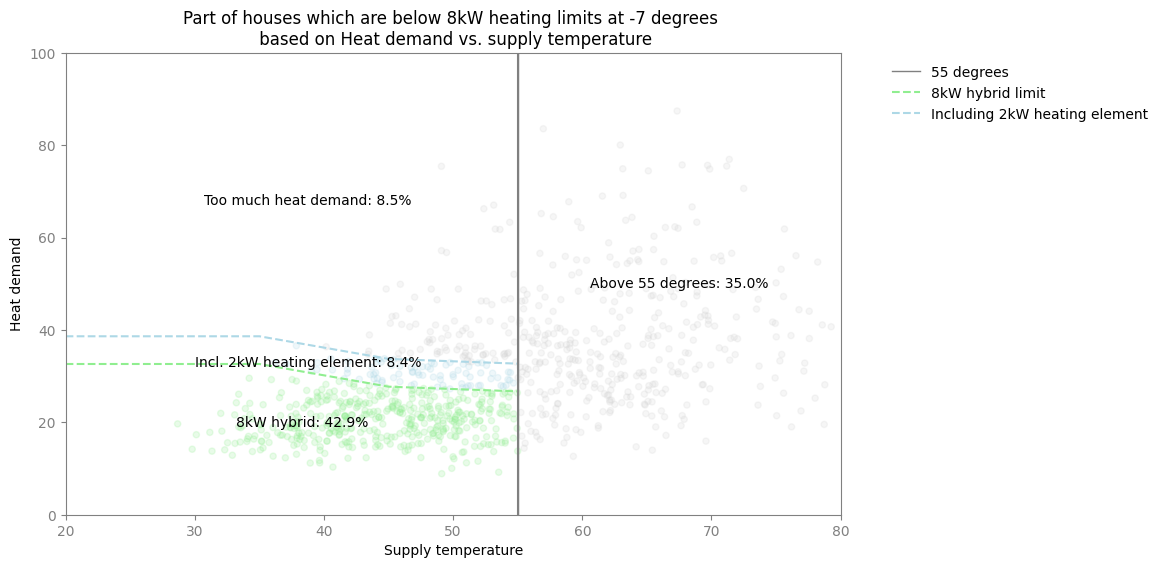

In [108]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

shl = single_hybrid_limits = [4.748+2.5, 3.627+2.5, 3.360+2.5]
dhl = double_hybrid_limits = [8.375+2.5, 6.739+2.5, 6.40+2.5]

hrs = 3
# possible polygon 1 hp
polygons = [
    {'x':[20, 35, 45, 55, 55, 20], 'y': [hrs*dhl[0], hrs*dhl[0], hrs*dhl[1], hrs*dhl[2], 0, 0], 'color': 'lightgreen', 'label': '8kW hybrid', 'id': 1},
    {'x':[20, 35, 45, 55, 55, 45, 35, 20], 'y': [hrs*dhl[0]+6, hrs*dhl[0]+6, hrs*dhl[1]+6, hrs*dhl[2]+6, hrs*dhl[2], hrs*dhl[1], hrs*dhl[0], hrs*dhl[0]], 'color': 'lightblue', 'label': 'Incl. 2kW heating element', 'id': 2},
    {'x':[55, 55, 80, 80], 'y': [0, 100, 100, 0], 'color': 'lightgrey', 'label': 'Above 55 degrees', 'id': 3},
    {'x':[20, 35, 45, 55, 55, 45, 35, 20], 'y': [100, 100, 100, 100, hrs*dhl[2]+6,hrs*dhl[1]+6,hrs*dhl[0]+6, hrs*dhl[0]+6], 'color': 'lightgrey', 'label': 'Too much heat demand','id':4},
]

# create a function that checks whether a point is inside a polygon
def point_in_polygon(point, polygon):
    return Polygon(polygon).contains_point(point)

# plot results
df_results['colors'] = df_results.apply(lambda row: next((polygon['color'] for polygon in polygons if point_in_polygon((row['supply_temperature_3hr'], row['heat_demand_3hr']), list(zip(polygon['x'], polygon['y'])))), None), axis=1)
df_results[df_results['colors'].notna()].plot(
    kind='scatter', x='supply_temperature_3hr', y='heat_demand_3hr', 
    alpha=0.2, 
    c=df_results[df_results['colors'].notna()]['colors'].tolist(),
    figsize=(10, 6)
)

for polygon in polygons:
    points_in_polygon = df_results.apply(lambda row: point_in_polygon((row['supply_temperature_3hr'], row['heat_demand_3hr']), list(zip(polygon['x'], polygon['y']))), axis=1)
    percentage = points_in_polygon.sum() / len(df_results) * 100
    plt.text(sum(polygon['x'])/len(polygon['x']), sum(polygon['y'])/len(polygon['y']), f'{polygon["label"]}: {percentage:.1f}%', horizontalalignment='center', verticalalignment='center')

# lines seperating different polygons
plt.axvline(x=55, color='grey', label='55 degrees',linewidth=1)
plt.plot(polygons[0]['x'][:4], polygons[0]['y'][:4], color=polygons[0]['color'], linestyle='--', label='8kW hybrid limit')
plt.plot(polygons[1]['x'][:4], polygons[1]['y'][:4], color=polygons[1]['color'], linestyle='--', label='Including 2kW heating element')


plt.title('Part of houses which are below 8kW heating limits at -7 degrees \n based on Heat demand vs. supply temperature')
plt.xlabel('Supply temperature')
plt.xlim(20, 80)
plt.ylim(0, 100)
plt.ylabel('Heat demand')
# plt.grid()


ax = plt.gca()
ax.tick_params(axis='x', colors='grey')
ax.tick_params(axis='y', colors='grey')
ax.spines[['bottom','left','right','top']].set_color('grey')

# add legend
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), frameon=False)

# plot vertical line at 55 degrees in grey
plt.axvline(x=55, color='grey')

plt.show()

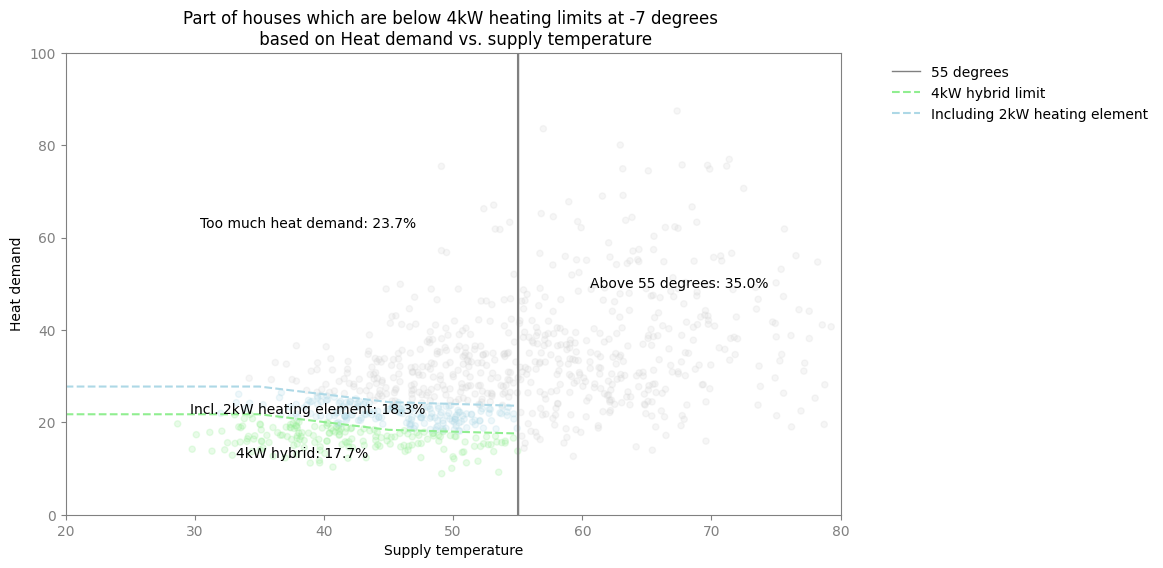

In [110]:
hrs = 3
# possible polygon 1 hp
polygons = [
    {'x':[20, 35, 45, 55, 55, 20], 'y': [hrs*shl[0], hrs*shl[0], hrs*shl[1], hrs*shl[2], 0, 0], 'color': 'lightgreen', 'label': '4kW hybrid', 'id': 1},
    {'x':[20, 35, 45, 55, 55, 45, 35, 20], 'y': [hrs*shl[0]+6, hrs*shl[0]+6, hrs*shl[1]+6, hrs*shl[2]+6, hrs*shl[2], hrs*shl[1], hrs*shl[0], hrs*shl[0]], 'color': 'lightblue', 'label': 'Incl. 2kW heating element', 'id': 2},
    {'x':[55, 55, 80, 80], 'y': [0, 100, 100, 0], 'color': 'lightgrey', 'label': 'Above 55 degrees', 'id': 3},
    {'x':[20, 35, 45, 55, 55, 45, 35, 20], 'y': [100, 100, 100, 100, hrs*shl[2]+6,hrs*shl[1]+6,hrs*shl[0]+6, hrs*shl[0]+6], 'color': 'lightgrey', 'label': 'Too much heat demand','id':4},
]

# create a function that checks whether a point is inside a polygon
def point_in_polygon(point, polygon):
    return Polygon(polygon).contains_point(point)

# plot results
df_results['colors'] = df_results.apply(lambda row: next((polygon['color'] for polygon in polygons if point_in_polygon((row['supply_temperature_3hr'], row['heat_demand_3hr']), list(zip(polygon['x'], polygon['y'])))), None), axis=1)
df_results[df_results['colors'].notna()].plot(
    kind='scatter', x='supply_temperature_3hr', y='heat_demand_3hr', 
    alpha=0.2, 
    c=df_results[df_results['colors'].notna()]['colors'].tolist(),
    figsize=(10, 6)
)

for polygon in polygons:
    points_in_polygon = df_results.apply(lambda row: point_in_polygon((row['supply_temperature_3hr'], row['heat_demand_3hr']), list(zip(polygon['x'], polygon['y']))), axis=1)
    percentage = points_in_polygon.sum() / len(df_results) * 100
    plt.text(sum(polygon['x'])/len(polygon['x']), sum(polygon['y'])/len(polygon['y']), f'{polygon["label"]}: {percentage:.1f}%', horizontalalignment='center', verticalalignment='center')

# lines seperating different polygons
plt.axvline(x=55, color='grey', label='55 degrees',linewidth=1)
plt.plot(polygons[0]['x'][:4], polygons[0]['y'][:4], color=polygons[0]['color'], linestyle='--', label='4kW hybrid limit')
plt.plot(polygons[1]['x'][:4], polygons[1]['y'][:4], color=polygons[1]['color'], linestyle='--', label='Including 2kW heating element')


plt.title('Part of houses which are below 4kW heating limits at -7 degrees \n based on Heat demand vs. supply temperature')
plt.xlabel('Supply temperature')
plt.xlim(20, 80)
plt.ylim(0, 100)
plt.ylabel('Heat demand')
# plt.grid()


ax = plt.gca()
ax.tick_params(axis='x', colors='grey')
ax.tick_params(axis='y', colors='grey')
ax.spines[['bottom','left','right','top']].set_color('grey')

# add legend
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), frameon=False)

# plot vertical line at 55 degrees in grey
plt.axvline(x=55, color='grey')

plt.show()

## results
- clients right now: 8kw / 4kw
- 24hr plot (green / blue / grey) -> blue = grey i.e. (only green can switch)
- 3hr plot (green / orange / blue / grey) -> grey = cannot switch, blue = maybe / possible

- clients that have a 4kW now:
- 24hr plot (green / blue / grey) -> blue = grey i.e. (only green can switch)
- 3hr plot (green / orange / blue / grey) -> grey = cannot switch, blue = maybe / possible


- 8kW hybrid: which are in green (in both graphs): 8kW ready for upgrade
- 8kW hybrid: in green (24hr) in blue (3hr): maybe 

## Deep dive into results of Uniformly distributed daily limit

In [ ]:
# To improve
# Filter supply temperature also on supervisoryControlMode on (2, 3, 4)
# we can filter based on first date of availability of data (half november 2023)

In [281]:
df_cics[df_cics['ambientTemperature']<5]

,cic_id,d,ambientTemperature,supplyTemperature,supplyTemperatureOos,roomTemperatureError,roomSetTemperature,roomTemperature,Q_hp_24hr,Q_hp1_24hr,...,Q_hp_3hr_max,Q_hp1_3hr_max,Q_hp2_3hr_max,E_hp_3hr_max,E_hp1_3hr_max,E_hp2_3hr_max,Q_cv_3hr_max,hpHeatRatio_3hr_max,COP_3hr_max,supplyTemperature_3hr_max
59,CIC-002fd9e7-4ec3-5ba0-9887-8200ac406ae9,2023-11-22,4.901573,38.499429,0.000000,-0.226190,19.125521,19.351711,119.468,55.515,...,20.894,10.541,10.353,8.005,3.960,4.045,12.573,0.624316,2.610119,50.942514
62,CIC-002fd9e7-4ec3-5ba0-9887-8200ac406ae9,2023-11-25,4.831787,35.951200,0.000000,-0.138303,18.778258,18.916561,99.340,51.907,...,21.877,11.613,10.264,7.667,4.238,3.429,12.887,0.629300,2.853398,53.693329
63,CIC-002fd9e7-4ec3-5ba0-9887-8200ac406ae9,2023-11-26,4.950898,38.701467,0.000000,-0.002257,18.820137,18.822393,120.930,56.373,...,22.296,11.817,10.479,8.119,4.110,4.009,17.027,0.566996,2.746151,55.268194
64,CIC-002fd9e7-4ec3-5ba0-9887-8200ac406ae9,2023-11-27,3.944160,34.785162,0.000000,-0.061600,18.560243,18.621843,99.021,46.021,...,22.938,11.642,11.296,7.778,3.949,3.829,9.565,0.705719,2.949087,50.282714
65,CIC-002fd9e7-4ec3-5ba0-9887-8200ac406ae9,2023-11-28,1.315665,42.836443,0.000000,0.033363,18.946875,18.913512,113.164,54.423,...,18.870,10.114,8.756,8.696,4.509,4.187,29.032,0.393929,2.169963,60.268546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84489,CIC-ff04bf46-fc1f-5b89-9486-952183e177c7,2023-12-04,1.145100,32.806127,0.004514,-0.853964,18.170792,19.024756,54.536,54.536,...,11.030,11.030,0.000,4.222,4.222,0.000,5.811,0.654949,2.612506,44.918397
84490,CIC-ff04bf46-fc1f-5b89-9486-952183e177c7,2023-12-05,0.682132,31.329480,0.003125,-0.767611,18.183161,18.950773,49.704,49.704,...,8.859,8.859,0.000,3.306,3.306,0.000,8.694,0.504700,2.679673,45.181949
84491,CIC-ff04bf46-fc1f-5b89-9486-952183e177c7,2023-12-06,2.995761,32.008819,0.003138,-0.765534,18.383038,19.148571,56.332,56.332,...,11.439,11.439,0.000,4.022,4.022,0.000,6.614,0.633634,2.844107,42.152786
84492,CIC-ff04bf46-fc1f-5b89-9486-952183e177c7,2023-12-07,0.440642,31.945514,0.003125,-0.791213,18.209462,19.000675,48.867,48.867,...,8.880,8.880,0.000,3.428,3.428,0.000,7.954,0.527504,2.590432,47.490633


In [279]:
df_results[df_results['supply_temperature']<30]

,cic_id,heat_demand,supply_temperature,polygon,colors
1,CIC-00193b0f-c766-5466-b59a-c3aa1cf15c86,77.090658,29.353673,lightgreen,lightgreen
27,CIC-00fd581d-656d-506b-9548-467d174946d6,108.173557,27.536321,lightgreen,lightgreen
34,CIC-017be24e-5cfb-552f-8f75-92bf303f89f7,93.882037,28.116919,lightgreen,lightgreen
40,CIC-01c2363b-dd68-5b47-a82b-cfaed3a1aa52,86.645258,29.796117,lightgreen,lightgreen
41,CIC-01c7f1d8-8d1a-5f3a-b2a8-73b9868568e7,67.289351,29.224379,lightgreen,lightgreen
...,...,...,...,...,...
4674,CIC-ff166a5c-5c87-5ef3-b2c7-4b3200af7155,73.782752,29.645652,lightgreen,lightgreen
4678,CIC-ff67dd59-4a79-5e06-8d22-115416e4be9b,61.506670,24.560544,lightgreen,lightgreen
4684,CIC-ffb65bfc-aa61-5b67-aee9-e31e71b63daa,72.019162,29.462253,lightgreen,lightgreen
4688,CIC-ffda3016-6776-50e0-9e34-da189ee90622,72.974944,26.884676,lightgreen,lightgreen


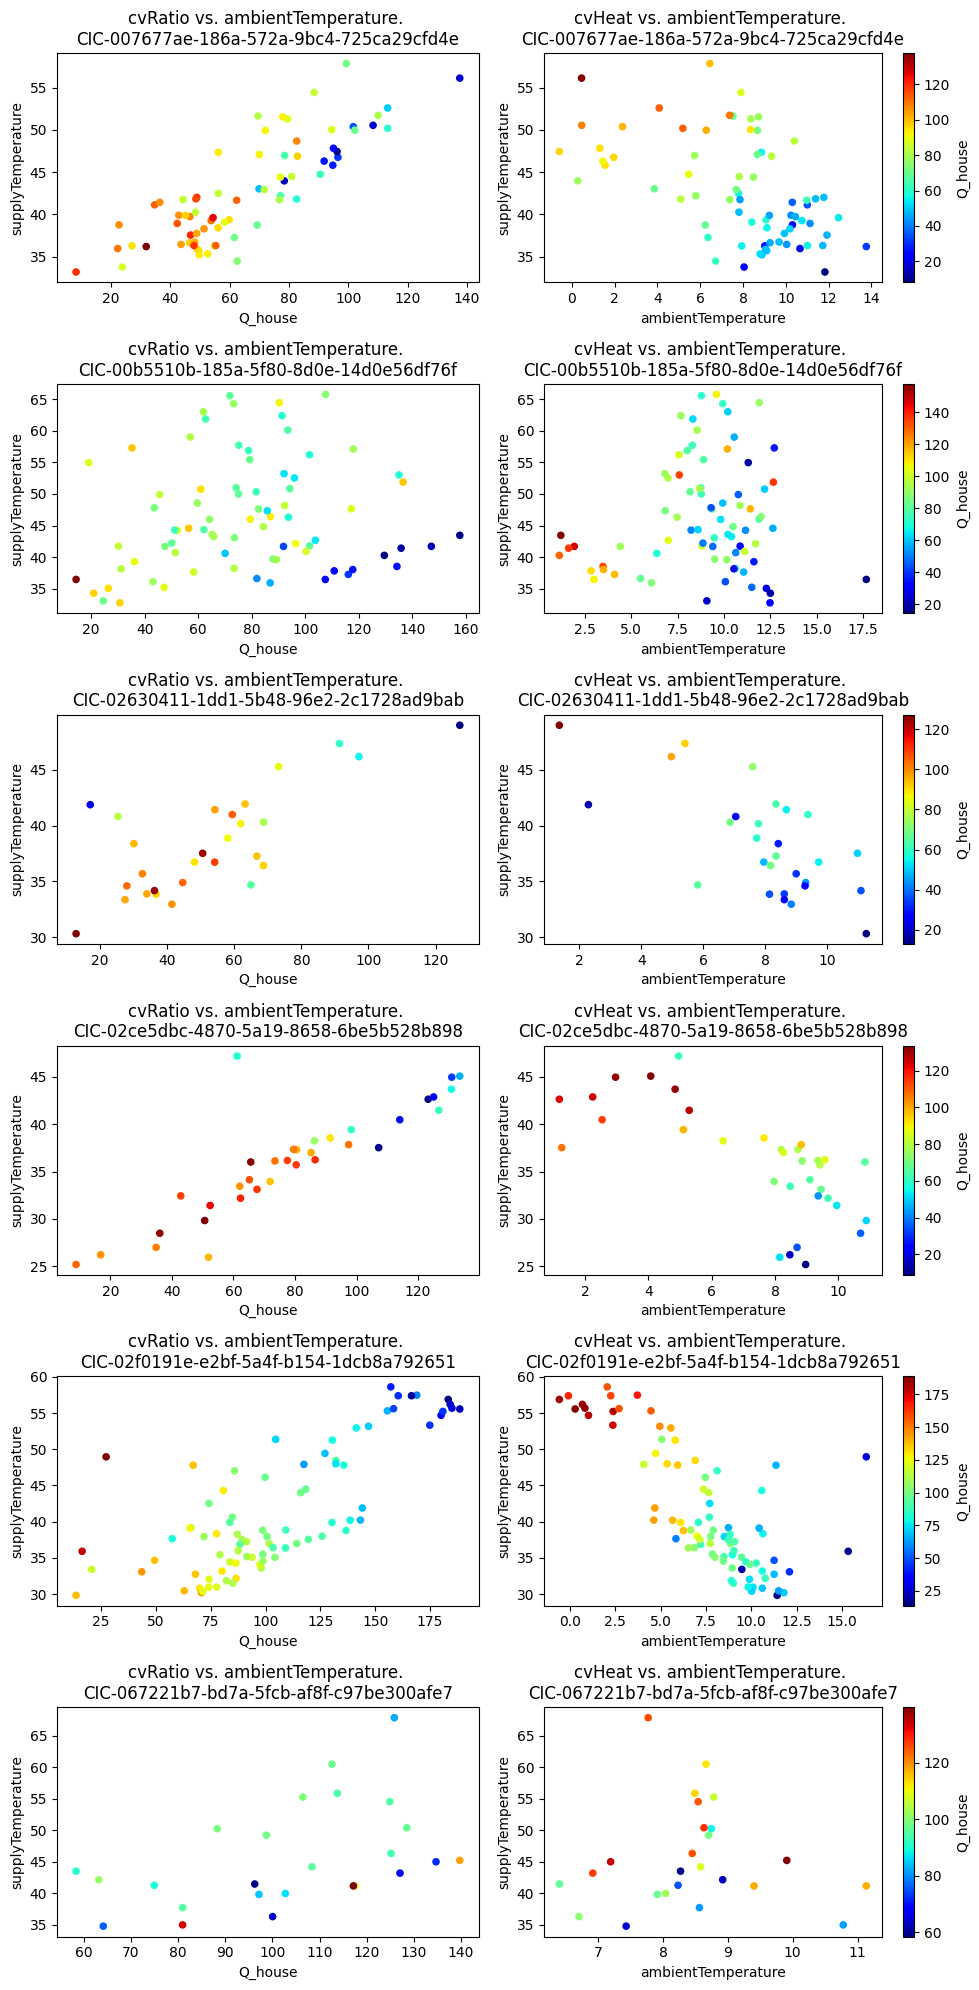

In [207]:
cics = df_results[df_results['supply_temperature']>50]['cic_id'].unique()

fig, axs = plt.subplots(6, 2, figsize=(10, 20))
axs = axs.flatten()  # Flatten the array of axes to easily iterate over it

for i, cic in enumerate(cics[:6]):  # Change the slice to select the first 6 cics
    df_cic = df_cics[df_cics['cic_id'] == cics[i]]
    
    df_cic.plot(kind='scatter', x='Q_house', y='supplyTemperature', 
                ax=axs[i*2], label=cic, c='ambientTemperature', cmap='jet')
    axs[i*2].set_title(f'cvRatio vs. ambientTemperature. \n{cic}')
    axs[i*2].get_legend().remove()
    axs[i*2].collections[0].colorbar.remove()
    df_cic.plot(kind='scatter', x='ambientTemperature', y='supplyTemperature', 
                 ax=axs[i*2+1], label=cic, c='Q_house', cmap='jet')
    axs[i*2+1].set_title(f'cvHeat vs. ambientTemperature. \n{cic}')
    axs[i*2+1].get_legend().remove()




plt.tight_layout()  # Adjust the layout so that the plots do not overlap
plt.show()